# **Part A: Classification of Customer Defaulting Payment**


Name: Liang Zheng Kai Lucas
<br>
<br>
Admin Number: P2222770
<br>
<br>
Class: DAAA/2A/06

**<font size=4>
Prediction Task**

**How is your prediction task defined?**

This dataset contains data on customer information owned by a bank. It also includes the status (i.e. default/no default) as well as other information such as bill and payment amounts of customers. If a customer defaults on their payments, it is bad for a bank as this could lead to harmful consequences such as a loss of revenue. 

Hence, the task is to create a classication model that predicts whether a customer would default thier payment based on cutomer features

**What is the meaning of the output variable?**

The output variable, Default payment next month, contains two class labels: 0 or 1.
* 0 indicates that the customer will pay the bill (non-default)
* 1 indicates that the customer will not pay the bill (default)

# Background Research

* Default payment occurs when customers miss one or multiple payments on money that has been borrowed (from the bank in this case)
* After breifly observing the data in the dataset, a few assumptions can be made:
    1) Bills are calculated based on how much of the previous bill was paid (e.g. if a person does not pay his bill in month 1, his bill is added with his bill for month 2 and the final value obtained is the bill amount for month 2)
    2) Bill amounts are on consecutive months
    3) Pay amounts are on consecutive months
* These assumptions would help make sense of how the bill amount columns (e.g. Bill_Amount1) corresponds to the pay amount columns (e.g. Pay_Amount1)

# References

* **scikit-learn:**
    * https://scikit-learn.org/stable/modules/classes.html

* **Background Research:**
    * https://www.investopedia.com/terms/d/default2.asp#:~:text=A%20default%20is%20a%20missed,or%20your%20monthly%20mortgage%20payment.

* **Pearson R:**
    * https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

* **Feature Selection:**
    * https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223

* **Oversampling:**
    * https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
    * https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

* **Images:**
    * https://stats.stackexchange.com/questions/351638/random-sampling-methods-for-handling-class-imbalance
    * https://medium.com/analytics-vidhya/smote-nc-in-ml-categorization-models-fo-imbalanced-datasets-8adbdcf08c25

# Importing Libraries

In [236]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt 
from numpy.random import rand

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_predict, cross_val_score, validation_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import learning_curve, ShuffleSplit

# EXTRA
# from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC

# Models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn import svm


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, chi2, mutual_info_classif

# Permutation Feature Importance
from sklearn.inspection import permutation_importance

from warnings import filterwarnings 
filterwarnings('ignore')

# Defining Utility functions

Functions that will be used

In [237]:
# Scoring models
def score_models_simple(X_train, y_train, models, metrics, cv):
    scores = []

    for name, model in models:
        model.fit(X_train, y_train)
        cv_score = cross_validate(model, X_train, y_train, scoring=metrics, cv=cv, n_jobs=2, return_train_score=True)
        scores.append(pd.Series(cv_score, name=name).apply(np.mean, axis=0))
        metrics_scores = pd.DataFrame(scores)

    return metrics_scores

def score_models(X_train, y_train, models, metrics, cv, steps, step, ax):
    scores = []

    for name, model in models:
        #pipeline
        steps[step] = (name, model)
        pipeline = Pipeline(steps=steps)
        # for i in range(len(models)):
        #     if models[i][0] == name:
        #         index = i
        #         break
        plot_learning_curve(
            pipeline,
            name,
            X_train,
            y_train,
            cv=None,
            n_jobs=None,
            train_sizes=np.linspace(0.1, 1.0, 5),
            ax=ax[models.index((name, model)) % 3, models.index((name, model)) // 3],
            # ax=ax[index % 3, index // 3]
        )
        model.fit(X_train, y_train)
        cv_score = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=cv, n_jobs=2, return_train_score=True)
        scores.append(pd.Series(cv_score, name=name).apply(np.mean, axis=0))
    return pd.DataFrame(scores)

# Plot learning curve
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    ax=None,):
    
    if ax is None :
        fig, ax = plt.subplots(figsize=(10,8))
    
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='recall', n_jobs=-1, train_sizes=train_sizes)

    # Create means and standard deviations of training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting
    ax.plot(train_sizes, train_scores_mean, 'o--', color='blue', label='Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-Validation score')

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)

    ax.set_xlabel('Training set size')
    ax.set_ylabel('Score')
    ax.legend(loc='best')
    ax.set_title(f'Learning Curve {title}')
    return ax

def plot_validation_curve_range(estimator, X_train, y_train, parameter_name, parameter_range):
    train_scores, test_scores = validation_curve(
        estimator=estimator,
        X=X_train,
        y=y_train,
        param_name=parameter_name,
        param_range=parameter_range,
        scoring="recall",
        n_jobs=-1
    )

    # Create means and standard deviations of training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting
    plt.plot(
        parameter_range, train_scores_mean, 'o--',label="Training score", color="navy", lw=2
    )
    
    plt.fill_between(parameter_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, lw=2)
    
    plt.plot(
        parameter_range, test_scores_mean, 'o-', label="Cross-validation score", color="darkorange", lw=2
    )
    
    plt.fill_between(parameter_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, lw=2)

    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Score')
    plt.ylim(0.0,1.1)
    plt.legend(loc='best')
    plt.title(f'Validation Curve with GaussianNB')
    return plt

# Data Exploration

* Conduct an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.
* To prevent the mutation of original data, I will make a copy to perform EDA on it
* The data set is constructed from the bank infromation of 1600 customers

**Metadata**
* Customer ID: Unique customer identifier ranging from 1 to 1600
* Credit Limit: The  credit limit for the customer
* Gender: Customer gender
* Education: Customer education level
* Marriage Status: Customer marital status
* Age: Rotational Customer age
* Bill_Amount1: Customer credit card bill amount 1 month ago
* Bill_Amount2: Customer credit card bill amount 2 month ago
* Bill_Amount3: Customer credit card bill amount 3 month ago
* Pay_Amount1: The amount customer paid 1 month ago
* Pay_Amount2: The amount customer paid 2 month ago
* Pay_Amount3: The amount customer paid 3 month ago
* Default payment next month: Whether customer will default next month, 1 means default (customer will not pay the bill), 0 means non default (customer will pay the bill)

In [238]:
# Import the dataset
credit_df = pd.read_csv('../../datasets/credit_dataset.csv')
credit_df

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1596,480000,female,univeresity,married,35,18214,11031,182123,0,182123,12960,0
1596,1597,150000,female,univeresity,married,37,1184,794,2756,0,2772,0,0
1597,1598,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0
1598,1599,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0


In [239]:
credit_eda = credit_df.copy()

# Descriptive Analysis

In [240]:
credit_eda.shape

(1600, 13)

This dataset has 1600 rows and 13 columns.

In [241]:
credit_eda.head(5)

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0


* Taking a look at the first 5 rows of data, majority of columns contain numerical data
* Gender, Education and Marriage Status column contains categorical (nominal) data, which may need to be encoded later on.
* Customer ID contain identifiers for each customer.
* As this value does not provide any insight to my analysis, it would be best to drop this column.

In [242]:
descriptive_stats = credit_eda.describe().T
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
Customer ID,1600.0,800.500000,462.024530,1.0,400.75,800.5,1200.25,1600.0
Credit Limit,1600.0,166787.500000,129944.635707,10000.0,50000.00,140000.0,230000.00,700000.0
Age,1600.0,35.224375,9.404550,21.0,28.00,34.0,41.00,75.0
Bill_Amount1,1600.0,49263.408125,72687.106917,-14386.0,3138.00,20320.5,61602.75,507726.0
Bill_Amount2,1600.0,47726.644375,71476.217397,-13543.0,3288.25,19769.5,59891.75,509229.0
Bill_Amount3,1600.0,44531.051875,67164.064239,-9850.0,2321.50,19332.5,53857.25,499936.0
Pay_Amount1,1600.0,5547.646250,14085.471957,0.0,1000.00,2176.5,5021.00,239104.0
Pay_Amount2,1600.0,5230.494375,15569.605419,0.0,468.50,1904.0,4592.50,285138.0
Pay_Amount3,1600.0,4451.610625,12491.715387,0.0,226.50,1313.5,4000.00,222750.0
Default payment next month,1600.0,0.212500,0.409205,0.0,0.00,0.0,0.00,1.0


* The columns Credit Limit, Bill_Amount1, Bill_Amount2, Bill_Amount3, Pay_Amount1, Pay_Amount2, Pay_Amount3 contains values of high magnitude compared to others columns, and thus they will need to be scaled.

In [243]:
credit_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Customer ID                 1600 non-null   int64 
 1   Credit Limit                1600 non-null   int64 
 2   Gender                      1600 non-null   object
 3   Education                   1600 non-null   object
 4   Marriage Status             1600 non-null   object
 5   Age                         1600 non-null   int64 
 6   Bill_Amount1                1600 non-null   int64 
 7   Bill_Amount2                1600 non-null   int64 
 8   Bill_Amount3                1600 non-null   int64 
 9   Pay_Amount1                 1600 non-null   int64 
 10  Pay_Amount2                 1600 non-null   int64 
 11  Pay_Amount3                 1600 non-null   int64 
 12  Default payment next month  1600 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 162.6+ KB


* This dataset has no null values present
* Credit Limit, Age, Bill_Amount1, Bill_Amount2, Bill_Amount3, Pay_Amount1, Pay_Amount2, Pay_Amount3 are all continuous features
* Looking at the bill and pay features, it may be possible to engineer new features like Total_Bill and Total_Paymrnt for our model to use (however these may not be useful as forfeiting the specific bill informations may not allow our model to identify patterns ect)
* We will test the model with both the new and old features to see whihc produces a better result

# Univariate Analysis

**<font size = 3>
Output Variable**

Our output variable is the Default payment next month column. It is a binary column with two values:

* 0: Non Default 
* 1: Default

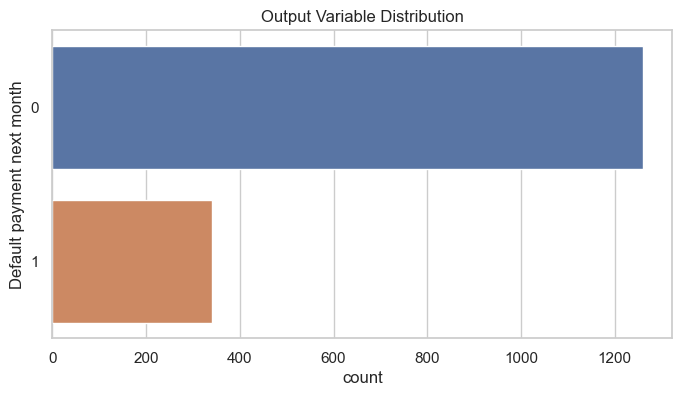

In [244]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Default payment next month'])
plt.title('Output Variable Distribution')
plt.show()

* Target feature is quite imbalanced with most customers not defaulting on payment.
* This suggests that defaulting payments is a rarer occurence compared to not defaulting
* An unbalanced dataset will bias the prediction model towards the majority class. Hence, it will need to be dealth with.
* There two approaches when dealing with imbalanced classes.
* Oversampling: Takes random samples for the minority class (default) and duplicates those samples to the length of the majority class (non default).
* Undersampling: Removes random samples from the majority class (non default) to the length of the minority class (default).
* Because undersampling will severely reduce the size of the dataset, the better approach would be to use oversampling.

**<font size = 3>
Age Distribution**

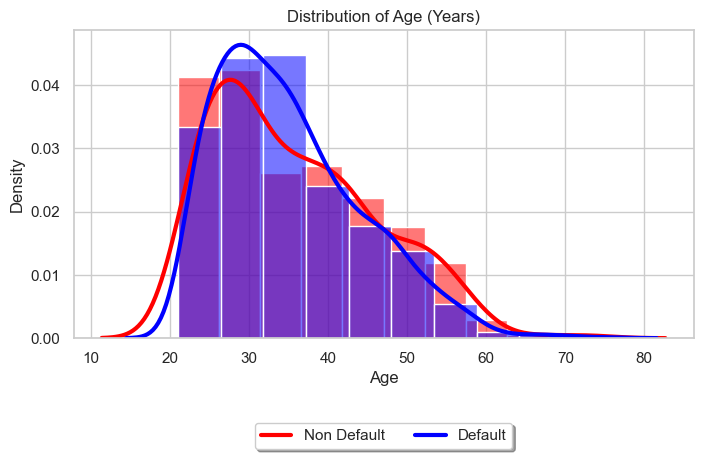

In [245]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Age'],
    density=True,
#     bins=20,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Age'],
    density=True,
#     bins=20,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Age"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Age"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Age (Years)")
plt.show()

* We see that the age of customers is positively skewed with the right tail extending 

**<font size = 3>
Credit Limit Distribution**

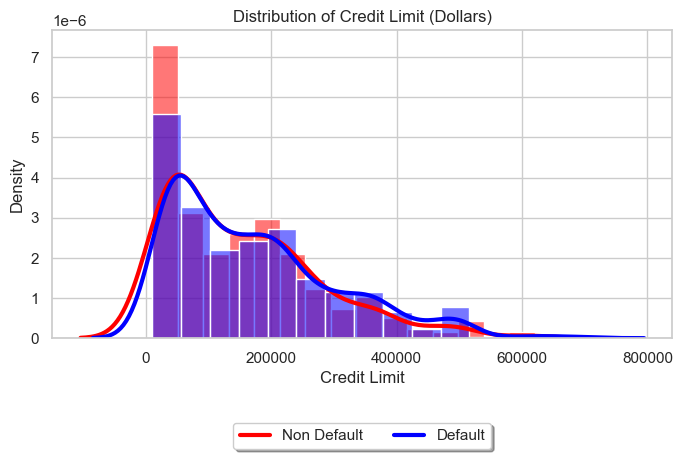

In [246]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Credit Limit'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Credit Limit'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Credit Limit"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Credit Limit"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Credit Limit (Dollars)")
plt.show()

**<font size=3>
Bill_Amount1, Bill_Amount2, Bill_Amount3 Distribution**

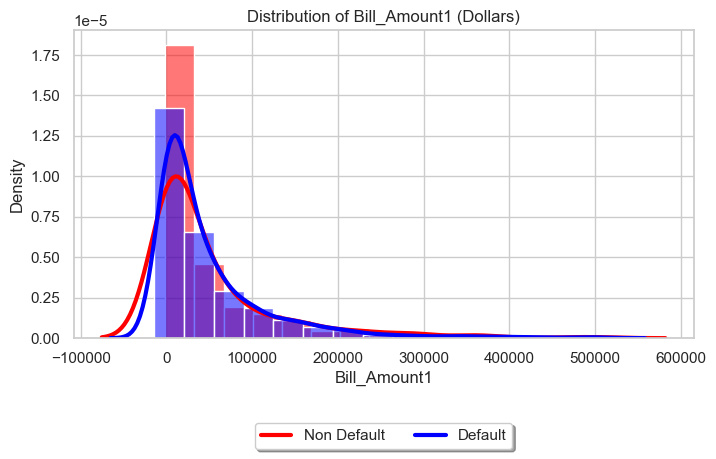

In [247]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Bill_Amount1'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Bill_Amount1'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Bill_Amount1"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Bill_Amount1"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Bill_Amount1 (Dollars)")
plt.show()

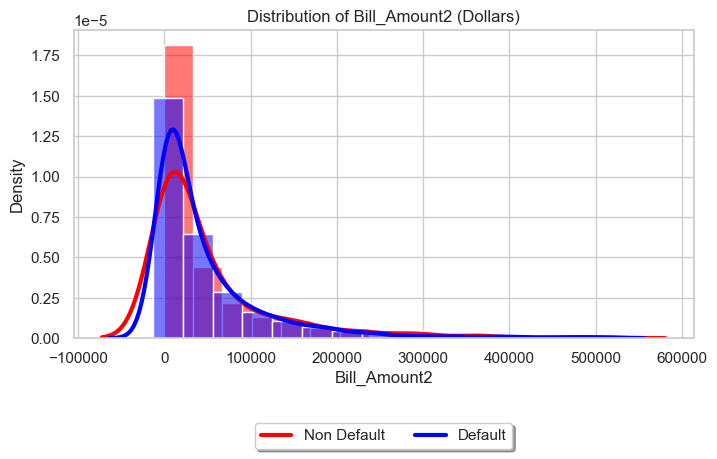

In [248]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Bill_Amount2'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Bill_Amount2'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Bill_Amount2"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Bill_Amount2"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Bill_Amount2 (Dollars)")
plt.show()

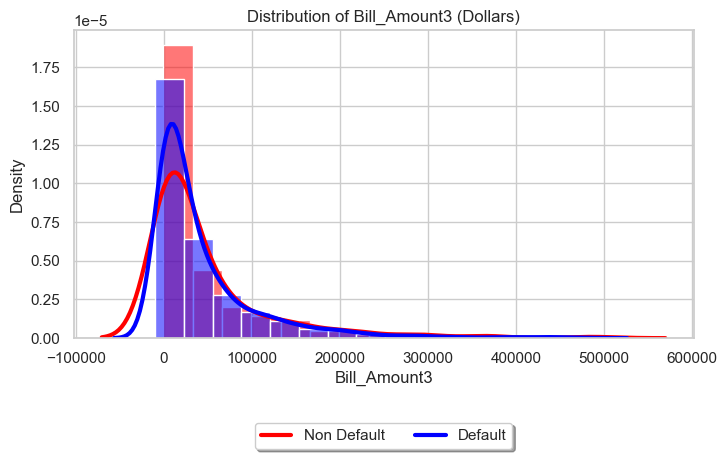

In [249]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Bill_Amount3'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Bill_Amount3'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Bill_Amount3"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Bill_Amount3"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Bill_Amount3 (Dollars)")
plt.show()

* From the graphs we see that the bill amount features are rougly have the same distribution as each other
* Their distribution is positively skewed with the right tail extending
* Notice that there are negative values for bills, this is because some customers may overay their bill, the negative values are an indicator of how much was overpayed (bill - payment)
* Thus, such values do not need to be dealt with (left alone)
* May need to be normalized with log scale or standard scaler

**<font size=3>
 Pay_Amount1, Pay_Amount2, Pay_Amount3 Distribution**

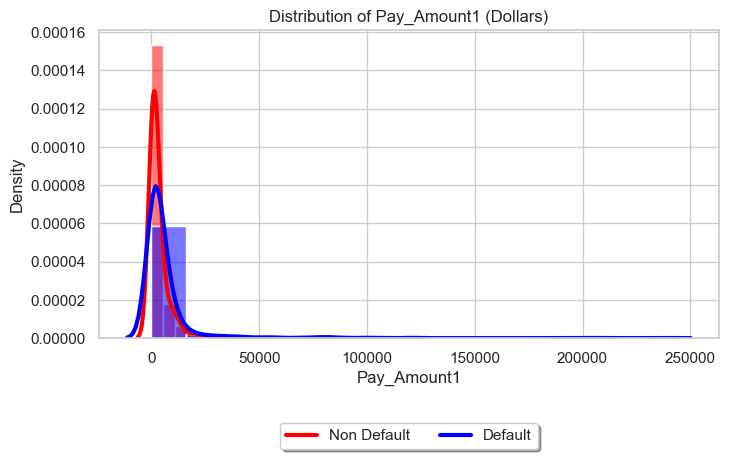

In [250]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Pay_Amount1'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Pay_Amount1'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Pay_Amount1"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Pay_Amount1"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Pay_Amount1 (Dollars)")
plt.show()

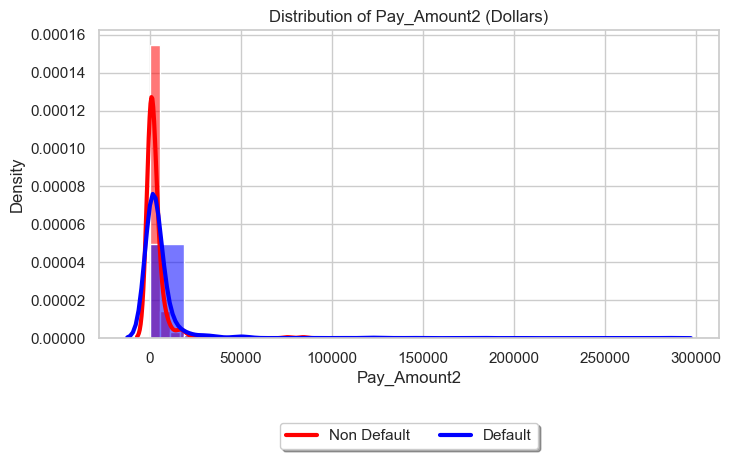

In [251]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Pay_Amount2'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Pay_Amount2'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Pay_Amount2"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Pay_Amount2"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Pay_Amount2 (Dollars)")
plt.show()

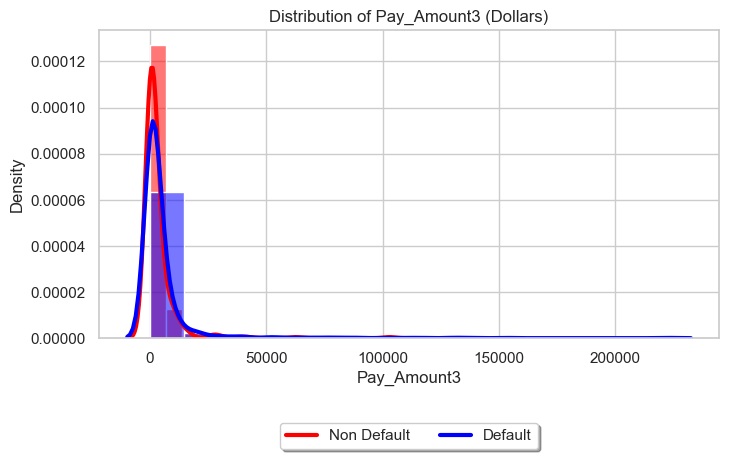

In [252]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Pay_Amount3'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Pay_Amount3'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Pay_Amount3"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Pay_Amount3"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Pay_Amount3 (Dollars)")
plt.show()

* From the graphs we see that the payment features are rougly have the same distribution as each other
* Their distribution is heavily positively skewed with the right tail extending
* May need to be normalized with log scale or standard scaler

**<font size=3>
Gender Count**

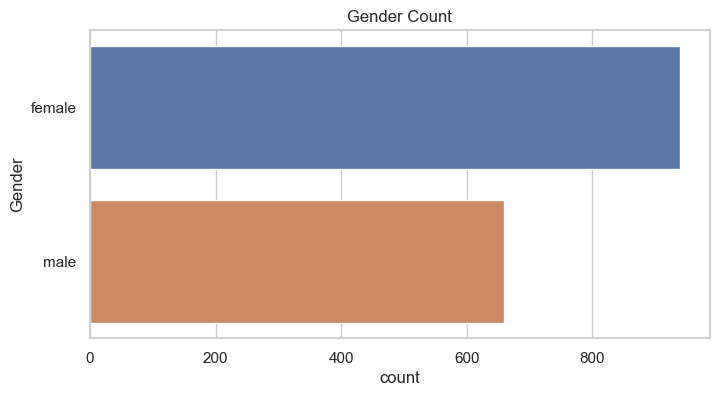

In [253]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Gender'])
plt.title('Gender Count')
plt.show()

**<font size=3>
Education Count**

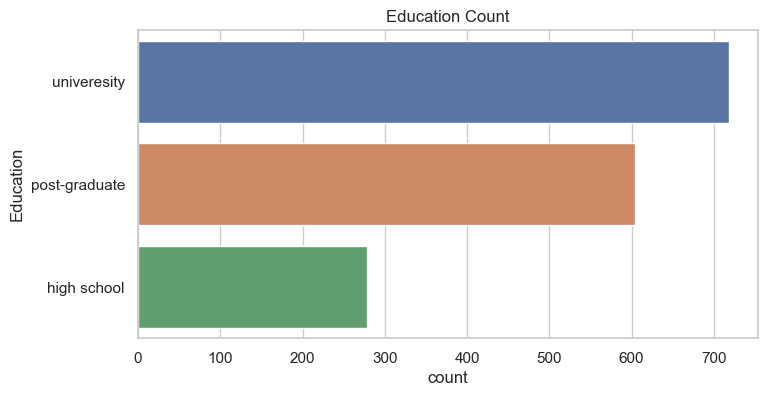

In [254]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Education'])
plt.title('Education Count')
plt.show()

**<font size=3>
Marriage Status Count**

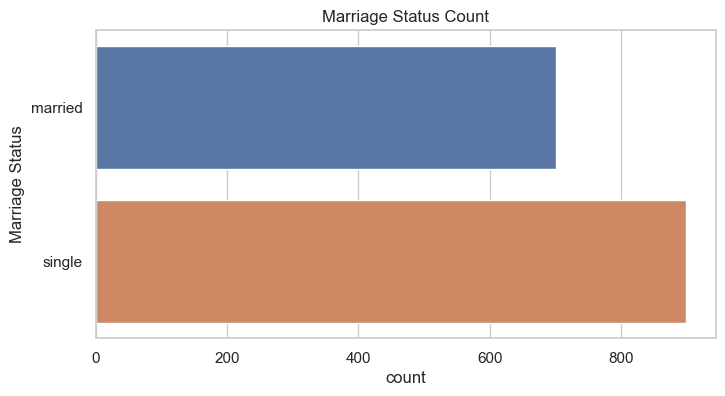

In [255]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Marriage Status'])
plt.title('Marriage Status Count')
plt.show()

* Majority of customer are females
* Majority of customers have finished education at the university level
* Majority of customers are single
* Such information may be important for the model's classification, thus we will retain them and perform encoding later on

# Bivariate Analysis

**<font size=3>
Pearson Correlation**

* The Pearson coefficient is a type of correlation coefficient that represents the relationship between two variables that are measured on the same interval or ratio scale and is a measure of the strength of the association between two continuous variables.



<font size=3>
$$
r =
  \frac{ \sum(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum(x_i-\bar{x})^2\sum(y_i-\bar{y})^2}}
$$

* Where r = correlation coefficient, $x_i$ = values of the x-variable in a sample, $\bar{x}$ = mean of the values of the x-variable, $y_i$ = values of the y-variable in a sample, $\bar{x}$ = mean of the values of the y-variable

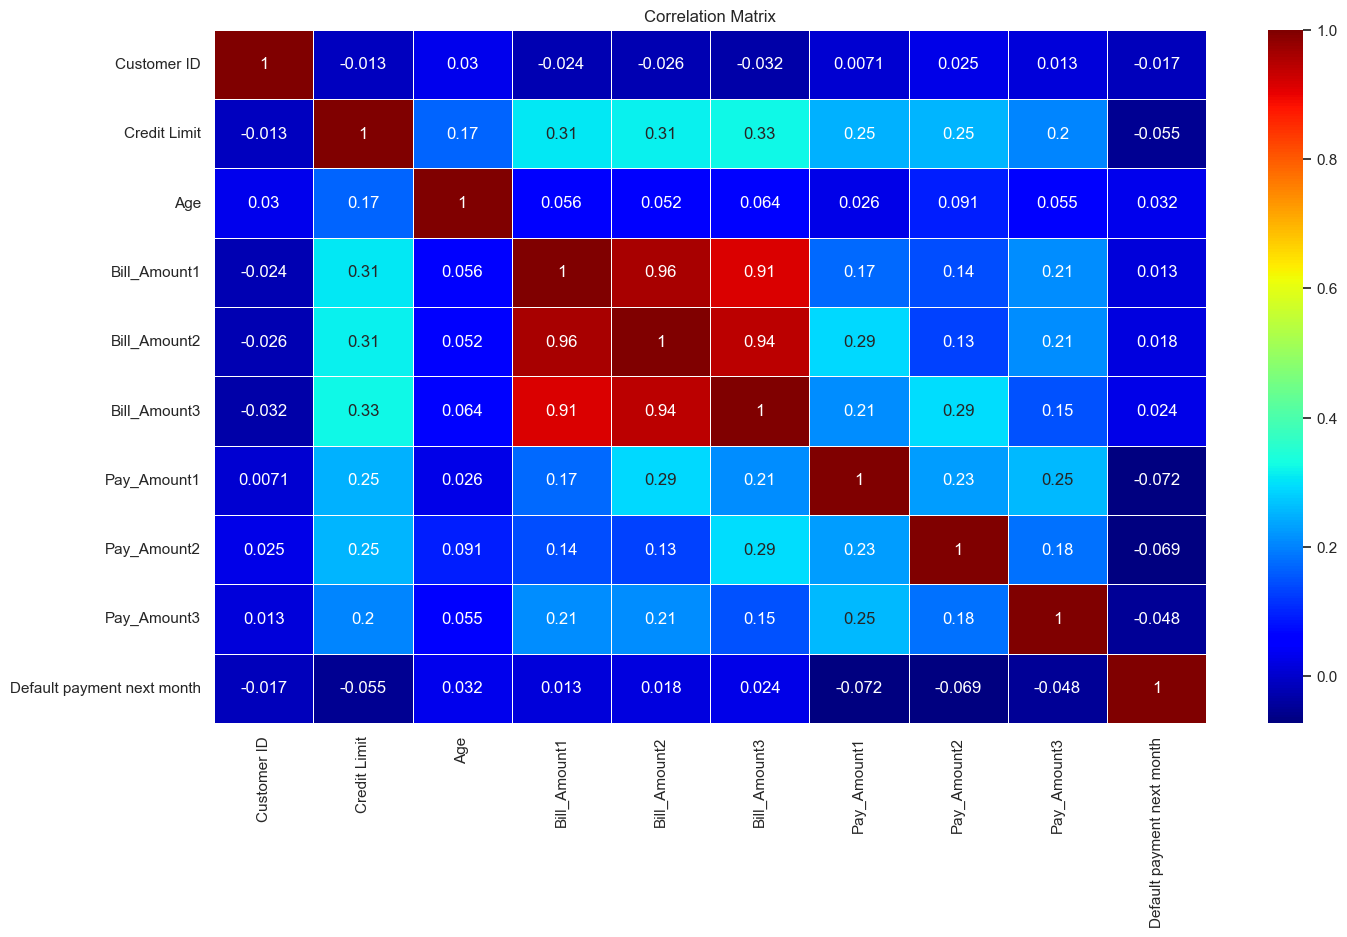

In [256]:
# Heatmap
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(credit_eda.corr(), annot=True, linewidths=.5, cmap='jet', ax=ax)
plt.title('Correlation Matrix')
plt.show()

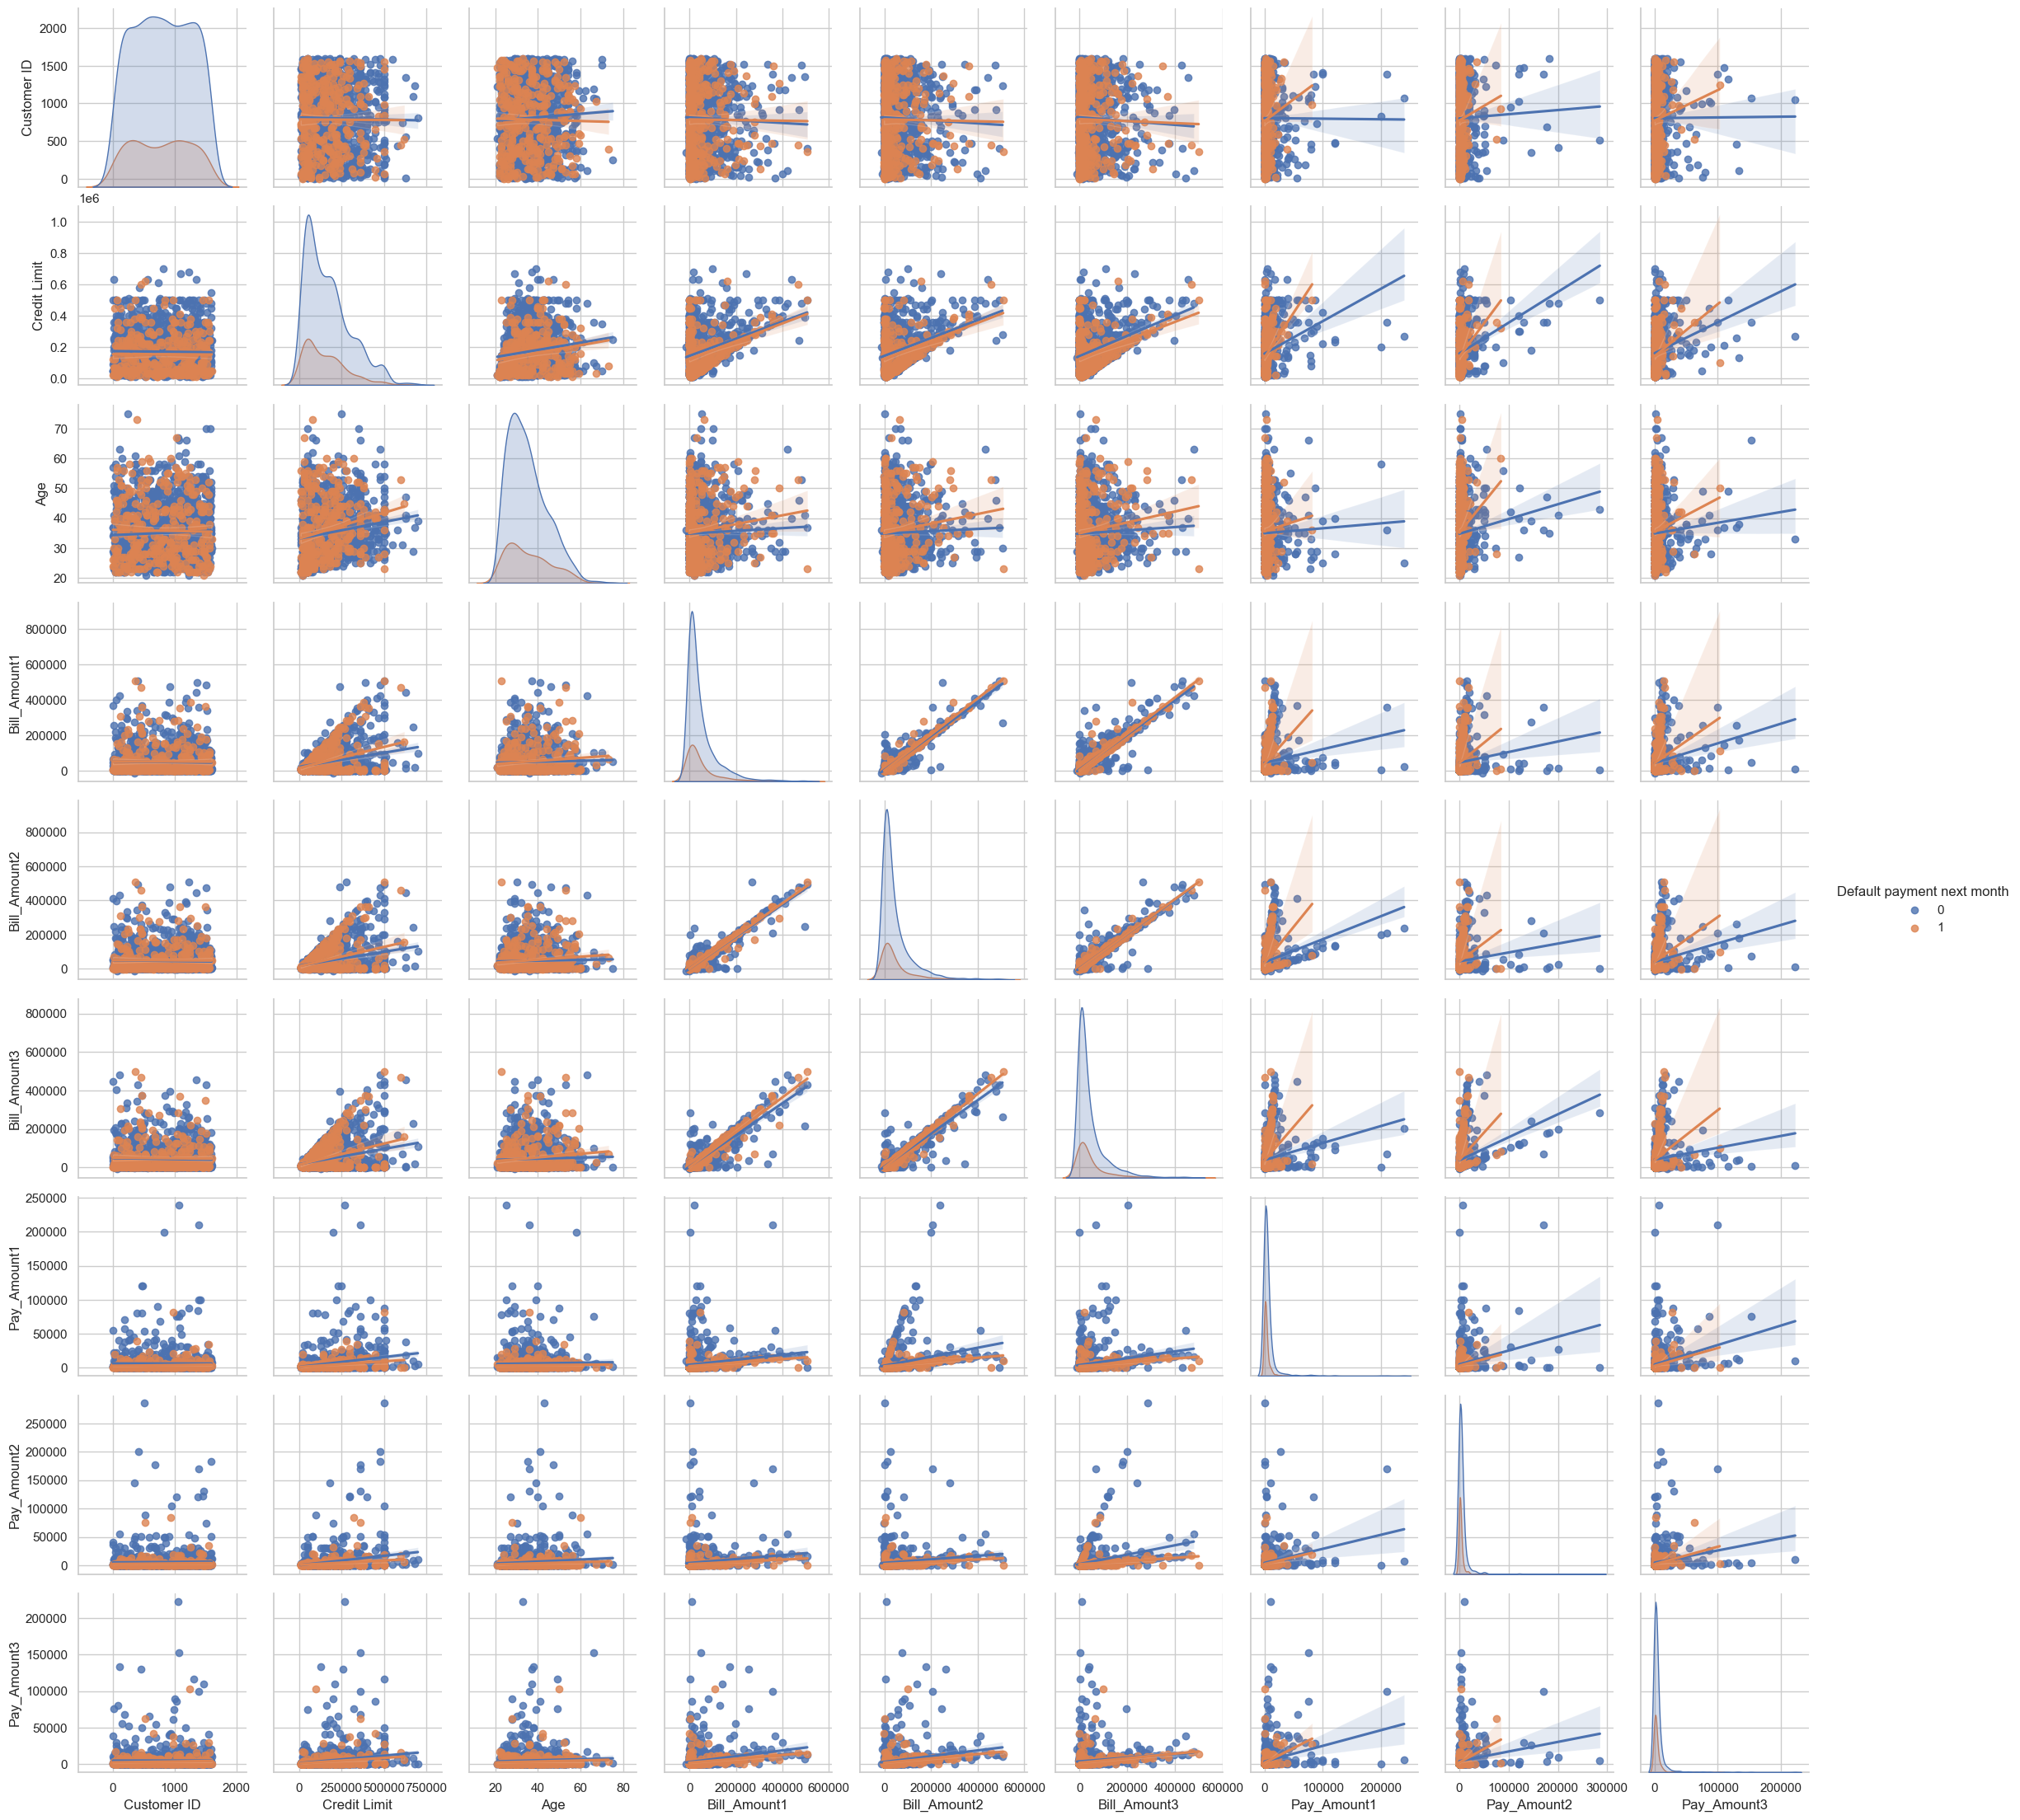

In [257]:
# Pairplot 
sns.set(style="whitegrid")
sns.pairplot(data=credit_eda, kind='reg', diag_kind='kde', hue='Default payment next month')
# plt.suptitle(f'{mode[0]}', y=1.01)
plt.show()

* Bill_Amount1 appears to have a very strong positive correlation with Bill_Amount2 and Bill_Amount3
* It could be because if the bill amounts are not paid off, they are accumulated 
* On the other hand, we observe that there is a weak positive relatinship between Credit and the Bill_Amount features as well as Pay_Amount features
* Lastly, we observe that Customer ID and Age have extremely weak (or close to no) correlation with other variables (and each other), prompting their removal

# Missing Values Analysis (check if we need imputation)

In [258]:
print(credit_eda.isna().sum().sort_values())

Customer ID                   0
Credit Limit                  0
Gender                        0
Education                     0
Marriage Status               0
Age                           0
Bill_Amount1                  0
Bill_Amount2                  0
Bill_Amount3                  0
Pay_Amount1                   0
Pay_Amount2                   0
Pay_Amount3                   0
Default payment next month    0
dtype: int64


* From this we can see that our data has no missing values 
* <span style ="color: green;"> This means during data preprocessing we can forgo imputation</span>

# Data Preprocessing

**Did you process the features in any way?**

After analysing our features, there are a few things we need to do for data preprocessing:
1) Feature engineer new columns (total payment over the 3 months)
2) Separate features
3) Encode categorical features
4) Train-Test Split
5) Scaling numerical features


**<font size=3>
Feature Engineering**

* Based on the given columns, we can perform some aggregation
* We can create the new feature: Total_Payment
* Total_Payment is the sum of values of each row of Pay_Amount1, Pay_Amount2, Pay_Amount3

In [259]:
credit_df['Total_Payment'] = credit_df['Pay_Amount1'] + credit_df['Pay_Amount2'] + credit_df['Pay_Amount3']

In [260]:
credit_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,1600.0,800.500000,462.024530,1.0,400.75,800.5,1200.25,1600.0
Credit Limit,1600.0,166787.500000,129944.635707,10000.0,50000.00,140000.0,230000.00,700000.0
Age,1600.0,35.224375,9.404550,21.0,28.00,34.0,41.00,75.0
Bill_Amount1,1600.0,49263.408125,72687.106917,-14386.0,3138.00,20320.5,61602.75,507726.0
Bill_Amount2,1600.0,47726.644375,71476.217397,-13543.0,3288.25,19769.5,59891.75,509229.0
Bill_Amount3,1600.0,44531.051875,67164.064239,-9850.0,2321.50,19332.5,53857.25,499936.0
Pay_Amount1,1600.0,5547.646250,14085.471957,0.0,1000.00,2176.5,5021.00,239104.0
Pay_Amount2,1600.0,5230.494375,15569.605419,0.0,468.50,1904.0,4592.50,285138.0
Pay_Amount3,1600.0,4451.610625,12491.715387,0.0,226.50,1313.5,4000.00,222750.0
Default payment next month,1600.0,0.212500,0.409205,0.0,0.00,0.0,0.00,1.0


**<font size=3>
Separating features**

In [261]:
X = credit_df.drop(['Customer ID', 'Age', 'Default payment next month'], axis=1)
y = credit_df[['Default payment next month']]

In [262]:
X

,Credit Limit,Gender,Education,Marriage Status,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Total_Payment
0,20000,female,univeresity,married,3913,3102,689,0,689,0,689
1,120000,female,univeresity,single,2682,1725,2682,0,1000,1000,2000
2,90000,female,univeresity,single,29239,14027,13559,1518,1500,1000,4018
3,50000,female,univeresity,married,46990,48233,49291,2000,2019,1200,5219
4,50000,male,univeresity,married,8617,5670,35835,2000,36681,10000,48681
...,...,...,...,...,...,...,...,...,...,...,...
1595,480000,female,univeresity,married,18214,11031,182123,0,182123,12960,195083
1596,150000,female,univeresity,married,1184,794,2756,0,2772,0,2772
1597,110000,female,post-graduate,single,107195,109443,106637,7845,4000,4000,15845
1598,240000,male,post-graduate,single,7744,7284,11234,7305,11263,10018,28586


* Drop Customer ID and Age from the rest of the features
* Easier preprocessing

**<font size=3>
Encode categorical features**

* Perform encoding of categorical features: Education, Gender, Marriage Status, using pandas dummies

In [263]:
# Education 
education_dummies = pd.get_dummies(X['Education'], drop_first=True)
# Gender
gender_dummies = pd.get_dummies(X['Gender'], drop_first=True)
# Marriage Status
status_dummies = pd.get_dummies(X['Marriage Status'], drop_first=True)

print(education_dummies.head(10))
print(gender_dummies.head(10))
print(status_dummies.head(10))

   post-graduate  univeresity
0              0            1
1              0            1
2              0            1
3              0            1
4              0            1
5              1            0
6              1            0
7              0            1
8              0            0
9              0            0
   male
0     0
1     0
2     0
3     0
4     1
5     1
6     1
7     0
8     0
9     1
   single
0       0
1       1
2       1
3       0
4       0
5       1
6       1
7       1
8       0
9       1


* Concatenate the results (dummies with the dataframe and drop the original columns)

In [264]:
# Concat
X = pd.concat([X, education_dummies], axis=1)
X = pd.concat([X, gender_dummies], axis=1)
X = pd.concat([X, status_dummies], axis=1)

# Drop columns
X = X.drop('Education', axis=1)
X = X.drop('Gender', axis=1)
X = X.drop('Marriage Status', axis=1)

In [265]:
X.head(10)

,Credit Limit,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Total_Payment,post-graduate,univeresity,male,single
0,20000,3913,3102,689,0,689,0,689,0,1,0,0
1,120000,2682,1725,2682,0,1000,1000,2000,0,1,0,1
2,90000,29239,14027,13559,1518,1500,1000,4018,0,1,0,1
3,50000,46990,48233,49291,2000,2019,1200,5219,0,1,0,0
4,50000,8617,5670,35835,2000,36681,10000,48681,0,1,1,0
5,50000,64400,57069,57608,2500,1815,657,4972,1,0,1,1
6,500000,367965,412023,445007,55000,40000,38000,133000,1,0,1,1
7,100000,11876,380,601,380,601,0,981,0,1,0,1
8,140000,11285,14096,12108,3329,0,432,3761,0,0,0,0
9,20000,0,0,0,0,0,0,0,0,0,1,1


* After encoding, new columns are generated
* 'single' column:
    * 0: married
    * 1: single
* 'male' column:
    * 0: female
    * 1: male
* 'post-graduate' and 'univeresity' column **respectively**:
    * 1,0: post-graduate
    * 0,1: univeresity
    * 0,0: high school

**<font size=3>
Train-Test Split**

In [266]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=.2, random_state=24)

X_training = X_train.copy()
y_training = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_training

(1280, 12) (1280, 1)
(320, 12) (320, 1)


,Credit Limit,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Total_Payment,post-graduate,univeresity,male,single
1266,220000,194961,197536,203251,7200,9000,10000,26200,0,1,0,0
463,230000,30141,131255,110503,120093,8034,3013,131140,1,0,0,1
475,60000,27199,28358,28937,1900,1400,1000,4300,0,1,0,1
234,60000,58203,36367,20934,1506,1298,1000,3804,0,1,0,0
41,70000,67521,66999,63949,3000,4500,4042,11542,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1107,120000,1188,2512,3444,2512,3444,1742,7698,0,1,0,0
896,110000,92610,94755,92351,4500,0,11300,15800,1,0,1,0
171,300000,688,3280,0,3288,0,4340,7628,1,0,0,1
526,20000,18649,18066,19040,0,1594,1000,2594,0,1,1,1


* To evaluate the chosen models, we do a train-test split of the data (80:20 ratio)
* We then train the model with the train data (80%)
* This allows me to simulate how my model would perform with new data or test data (20%)
* Stratifying the split ensures that the distribution of classes is the same in both the test and training set
* Create a copy the the training data to perform preproccesing on before implementing a pipepline when training the final model

**<font size=3>
Scaling Numerical Features**

* We will use Normalizer() on the data
* Normalizer transforms each sample in the data to have a unit norm
* The data will be rescaled in such a way that the values lie between -1 and 1

In [267]:
num_col = [
    "Credit Limit",
    "Bill_Amount1",
    "Bill_Amount2",
    "Bill_Amount3",
    "Pay_Amount1",
    "Pay_Amount2",
    "Pay_Amount3",
    "Total_Payment",
]

normalizer=Normalizer()

X_training[num_col] = normalizer.fit_transform(X_training[num_col])

In [268]:
X_training.head(10)

,Credit Limit,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Total_Payment,post-graduate,univeresity,male,single
1266,0.537288,0.476137,0.482426,0.496383,0.017584,0.021980,0.024422,0.063986,0,1,0,0
463,0.678407,0.088904,0.387149,0.325939,0.354226,0.023697,0.008887,0.386810,1,0,0,1
475,0.774186,0.350951,0.365906,0.373377,0.024516,0.018064,0.012903,0.055483,0,1,0,1
234,0.640775,0.621584,0.388385,0.223567,0.016083,0.013862,0.010680,0.040625,0,1,0,0
41,0.518643,0.500276,0.496408,0.473810,0.022228,0.033341,0.029948,0.085517,1,0,0,1
675,0.682764,0.491302,0.479179,0.248746,0.000000,0.022000,0.000000,0.022000,0,0,1,1
145,0.972946,0.097275,0.115061,0.142342,0.019459,0.029188,0.038918,0.087565,1,0,1,1
534,0.981950,0.047350,0.060076,0.045818,0.060252,0.047919,0.035488,0.143659,1,0,1,1
1407,0.742361,0.391081,0.385904,0.369938,0.019910,0.014926,0.049491,0.084327,0,1,0,0
1232,0.514038,0.470005,0.493209,0.512362,0.030842,0.030842,0.020562,0.082246,1,0,1,0


**<font size=3>
Visualize the scaled data**

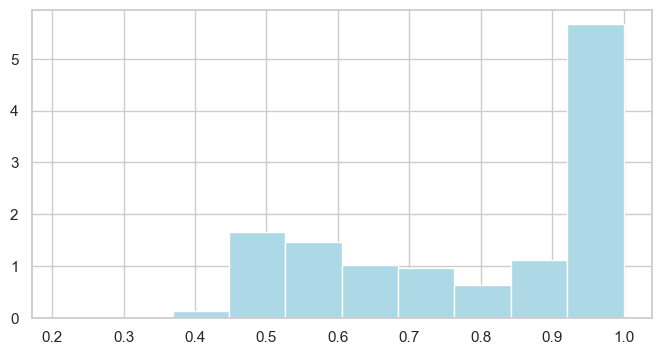

In [269]:
plt.hist(X_training["Credit Limit"], density=True, bins=10, color="#ADD8E6")
plt.show()

# Model Selection

**<font size=3>
Evaluation Methodology**

* I'll be using k-Fold Cross Validation to select candidate models after using data from the training-set
* I will then evaluate the final model using the test-set

**<font size=3>
Scoring Metrics**

* I will be using the confusion matrix and related metrics to view the performance of candidate models

**Optimizing Metric**
* In this problem, it is more important that our model is able to identify most if not all customers who might default payment in the next month
* Hence, we aim to make use of a classification metric that focuses on obtaining high true positives (i.e. recall)

**Recall Score**
* The Recall Score is defined as follows:

<font size=4>
$$Recall = \frac{\text{True Postives}}{\text{True Positives + False Negatives}}$$

* The Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values
* Thus, it is most suitable for this case as we aim to have a high score in order to correctly identify the highest amount of customers who would default payemnt
* Note that in this case our true positives are customers who actually defaulted
* Refer to the diagram below for further clarification:

<img src="../../pictures/diagram.png" alt="Diagram">

**<font size=3>
Satisficing Metrics**

**Model Interpretibility**
* The objective of the model is to help the bank identify which customer would most likey default payments in the next month, it is important for the bank to be able to identify factors used by the model
* This would allow for the bank to get a greater insight on customers likely to default payment even though they wern't identified by the model
* Hence, the model used should not be a black box, but rather show the factors that affect the final prediction. 
* This means that we will avoid black box models such as Artificial Neural Networks, and use models like Logistic Regression or Decision Trees

**Pipeline settings**

In [270]:
numeric_features = [
    "Credit Limit",
    "Bill_Amount1",
    "Bill_Amount2",
    "Bill_Amount3",
    "Pay_Amount1",
    "Pay_Amount2",
    "Pay_Amount3",
    "Total_Payment",
]

numeric_transformer = Pipeline(
    steps=[("Scaler", Normalizer())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric", numeric_transformer, numeric_features)
    ]
)

steps = [
    ('preprocessing', preprocessor),
    ('model'),
]

step = len(steps) - 1

* We use pipelines to prevent data leakage

In [271]:
metrics = ['precision', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

* Cross Validation is done across 5 folds

In [272]:
metrics = ['precision', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


models = [
    ("KNeighborsClassifer", KNeighborsClassifier()), 
    ("LogRegClassifier", LogisticRegression()), 
    ("DecisionTreeClassifer", DecisionTreeClassifier()), 
    ("RandomForestClassifier", RandomForestClassifier()), 
    ("GradientBoostClassifier", GradientBoostingClassifier()),
    ('SGDClassifier', SGDClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GaussianNB', GaussianNB()), # Naive Bayes
    ('ExtraTreesClassifier', ExtraTreesClassifier())
]

* Instantiating various models with default hyperparameters to pick a candidate model

**Viewing Scores**

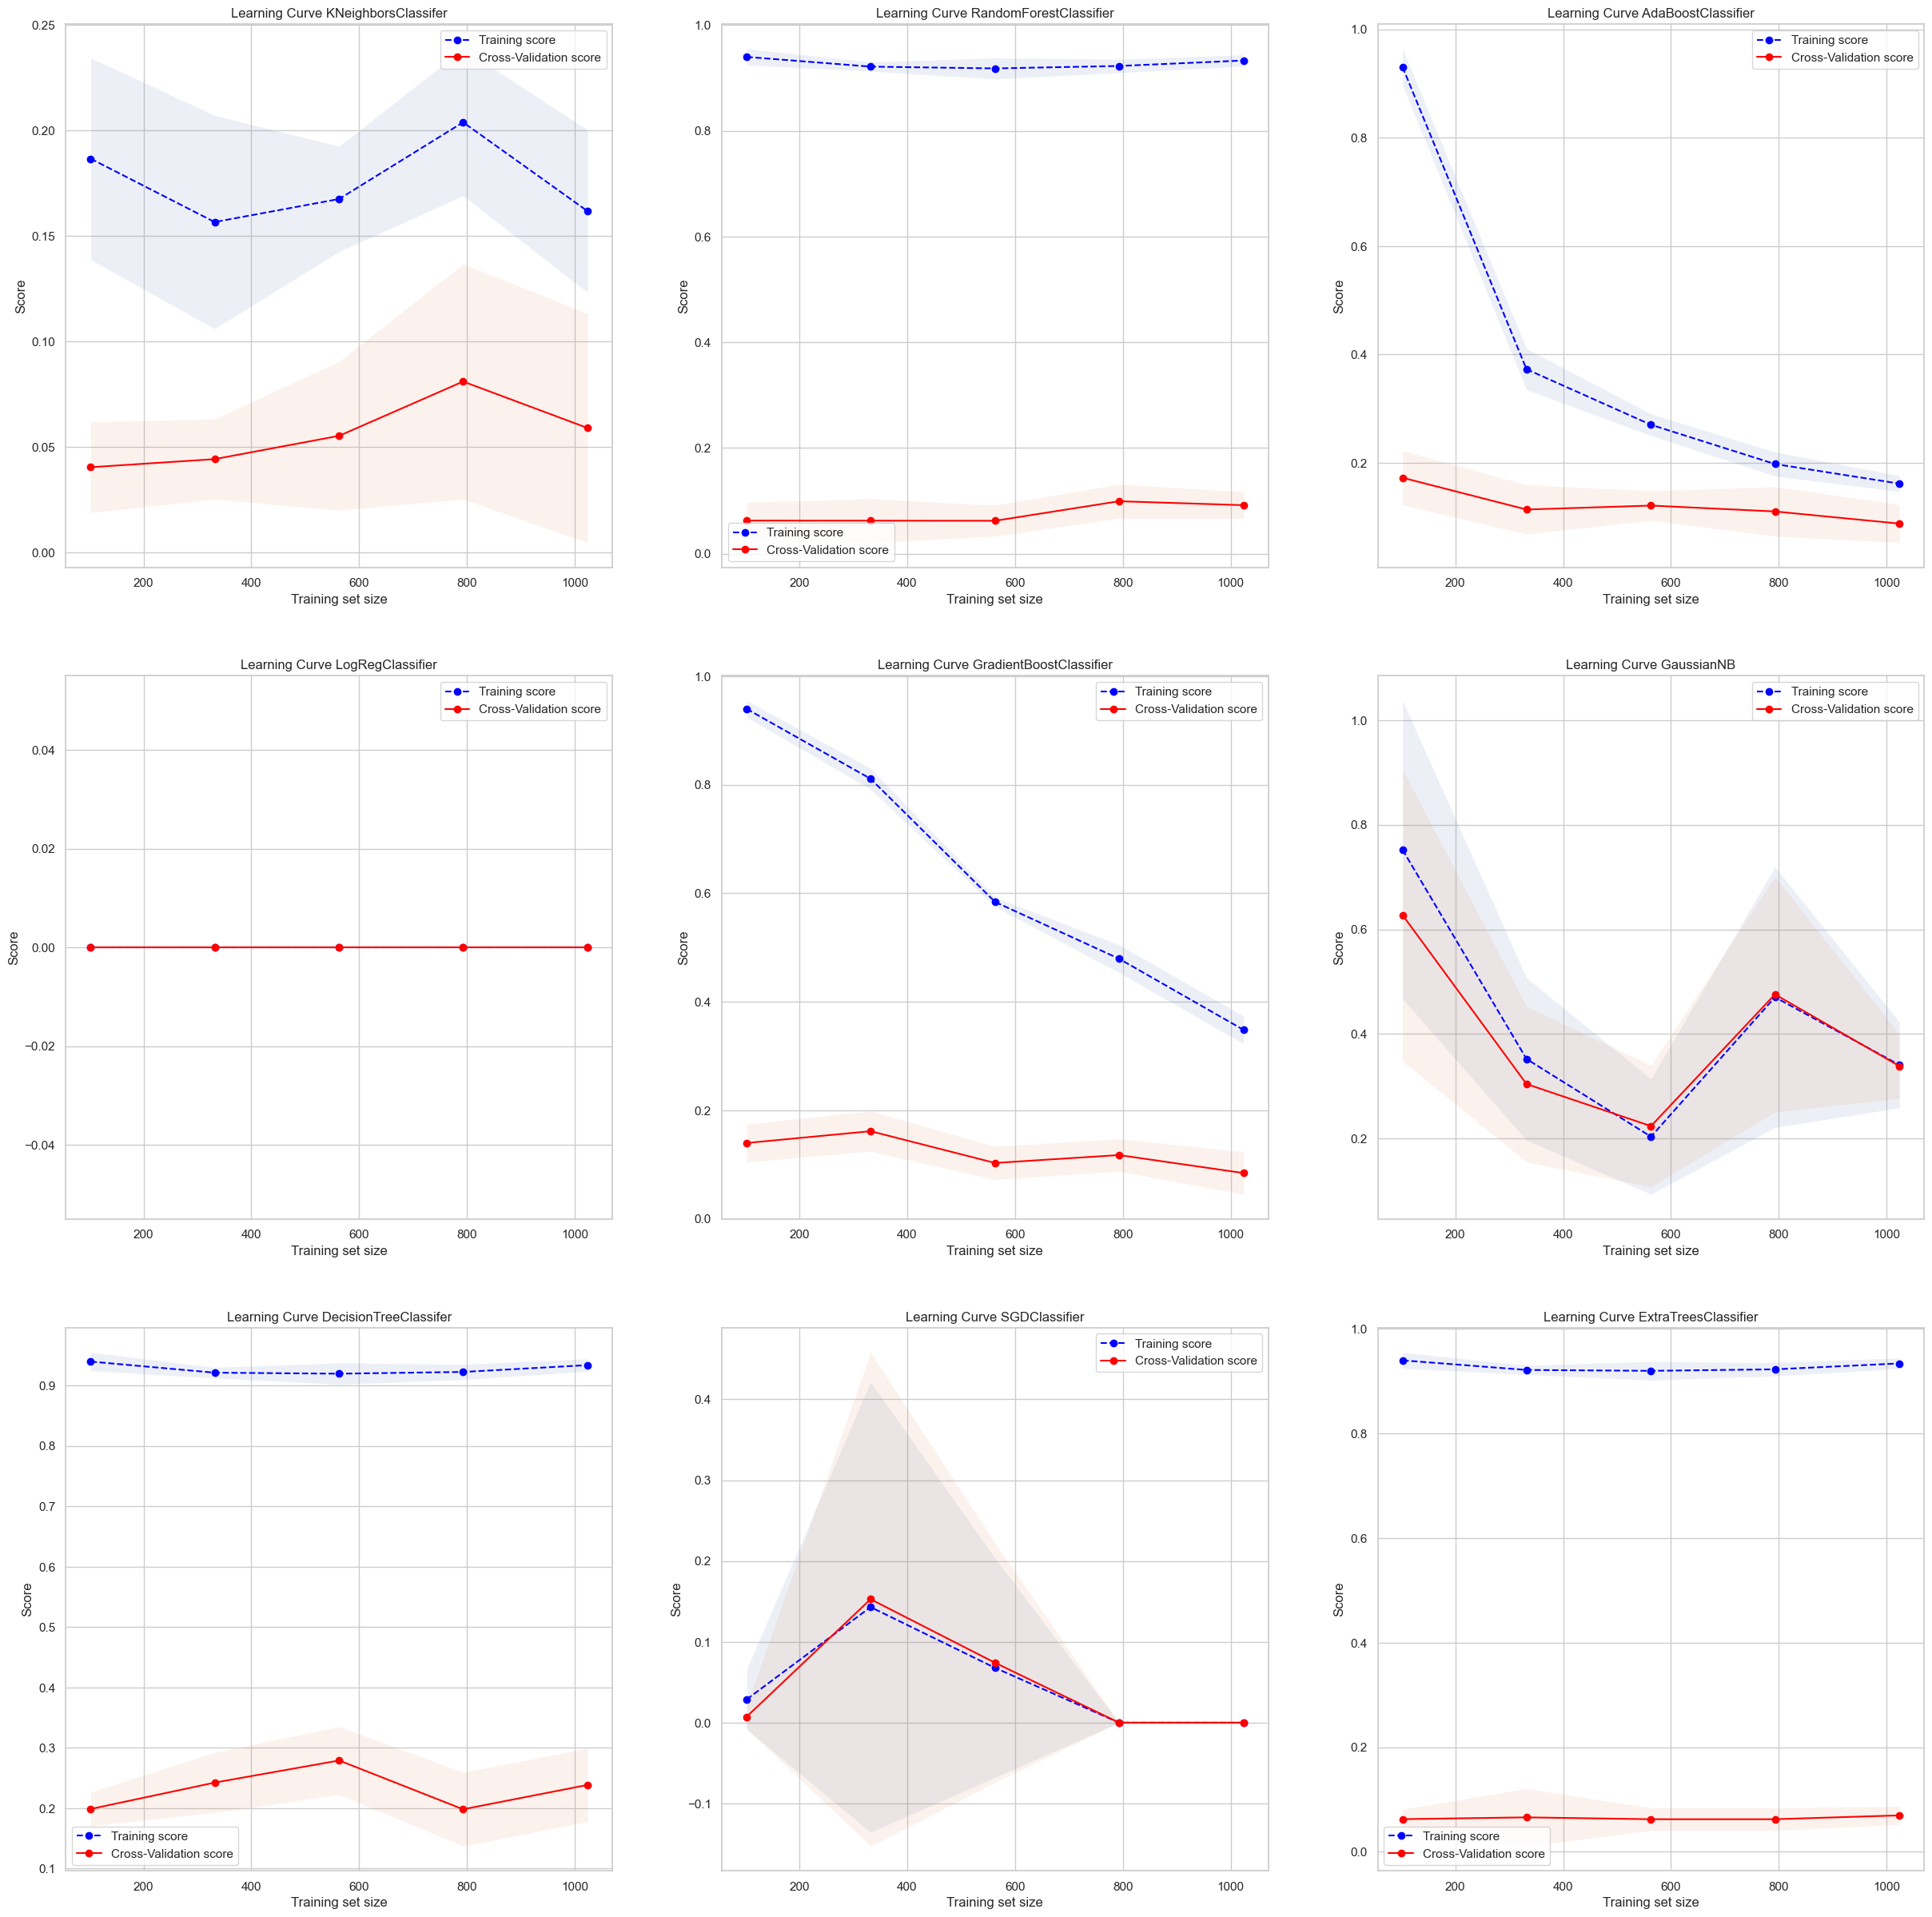

In [273]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
model_scores = score_models(X_train, y_train, models, metrics, cv, steps, step, ax)

In [274]:
model_scores.sort_values(by=['test_recall', 'train_recall', 'test_f1', 'train_f1'], ascending=False).style.apply(
    lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
).apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
GaussianNB,0.010571,0.041880,0.272472,0.246640,0.272989,0.228252,0.266960,0.230123,0.571263,0.528315
DecisionTreeClassifer,0.021548,0.038509,0.238652,1.000000,0.238461,0.934571,0.237331,0.966173,0.529653,0.998913
RandomForestClassifier,0.509234,0.076807,0.378603,1.000000,0.124159,0.934571,0.183488,0.966173,0.568798,0.998865
GradientBoostClassifier,0.627743,0.043683,0.380606,0.979468,0.094496,0.337868,0.146868,0.502191,0.606791,0.940784
KNeighborsClassifer,0.009792,0.054836,0.238832,0.530536,0.091298,0.154427,0.128427,0.235827,0.515255,0.779530
ExtraTreesClassifier,0.317906,0.091251,0.256658,1.000000,0.087936,0.934571,0.125050,0.966173,0.552665,0.998913
AdaBoostClassifier,0.225196,0.068024,0.343498,0.756261,0.076924,0.163652,0.123938,0.267343,0.625031,0.810570
LogRegClassifier,0.033510,0.070611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.619237,0.605682
SGDClassifier,0.015576,0.042467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.616258,0.618040


**How did you select which learning algorithm to use?**
* Most models perform very poorly even when more data is fitted to the model (cross validation score barely increases)
* The GaussianNB model does not have a very good learning curve, however its score is the best amongst the rest
* Hence, the model that performs best for the recall metric is the **GaussianNB** model, and this will be our candidate model

# Dummy (Baseline Model)

**What is a Dummy Classifer?**

* It is a classifier model that makes predictions without trying to find patterns in the data
* The default model essentially looks at what label is most frequent in the training dataset and makes predictions based on that label

In [275]:
steps[step] = ('model', DummyClassifier())
dummy = Pipeline(steps=steps)
dummy.fit(X_train, y_train)
cv_score = cross_validate(dummy, X_train, y_train, scoring=metrics, cv=cv, n_jobs=2, return_train_score=True)
dummy_score = pd.Series(cv_score, name='Dummy').apply(np.mean, axis=0)
dummy_score = pd.DataFrame(dummy_score).T
dummy_score

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
Dummy,0.009844,0.04938,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5


**Plot learning curve for dummy baseline**

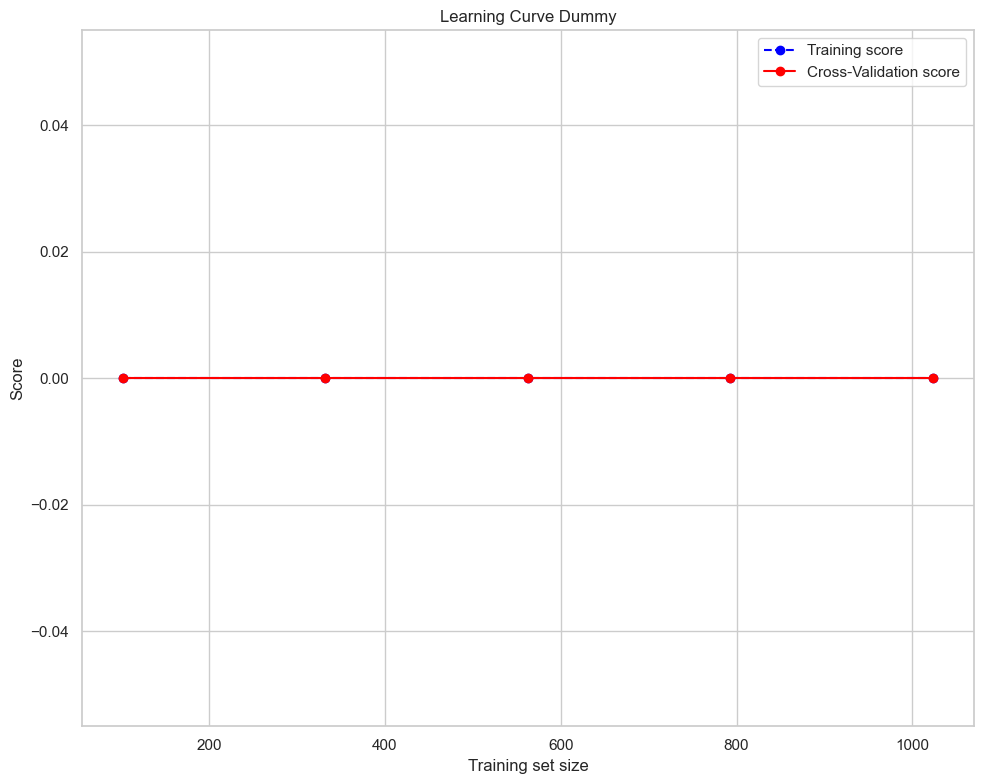

In [276]:
plot_learning_curve(dummy, 'Dummy', X_train, y_train, cv=cv, n_jobs=-1)
plt.tight_layout()
plt.show() 

* The baseline model is not able to perform at all
* The learning curve shows that the model's score(performance) on both the training set and the cross-validation set is 0
* This occurs due to the imbalance in the dataset
* Because of the lack of sampling techniques, the dummy model always predicts the majority class, hence the scores for all metrics execpt roc_auc is 0
* This will be further explained in the comparison between the baseline and selected model

# Gaussian NB with Default Hyperparameters (Selected Model)

In [277]:
steps[step] = ('GaussianNB', GaussianNB())
gnb = Pipeline(steps=steps)
gnb.fit(X_train, y_train)
cv_score = cross_validate(gnb, X_train, y_train, scoring=metrics, cv=cv, n_jobs=2, return_train_score=True)
gnb_score = pd.Series(cv_score, name='GaussianNB').apply(np.mean, axis=0)
gnb_score = pd.DataFrame(gnb_score).T
gnb_score

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
GaussianNB,0.014844,0.035972,0.272472,0.24664,0.272989,0.228252,0.26696,0.230123,0.571263,0.528315


**Plot learning curve for selected model**

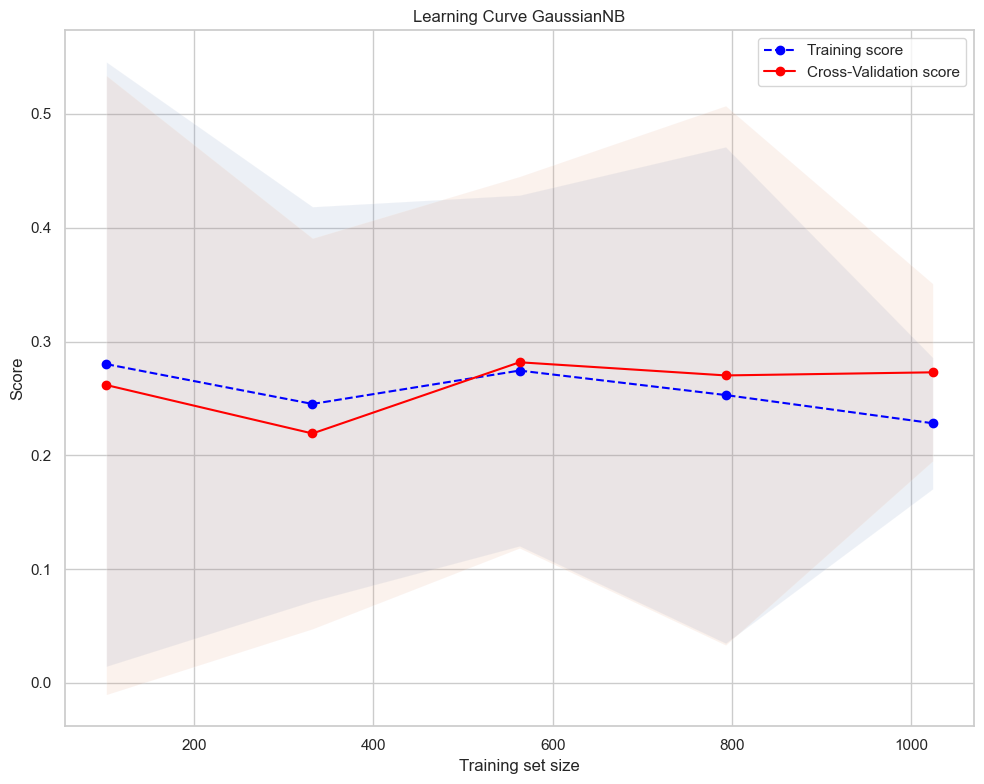

In [278]:
plot_learning_curve(gnb, 'GaussianNB', X_train, y_train, cv=cv, n_jobs=-1)
plt.tight_layout()
plt.show() 

**Observations**
* The GaussianNB model performs pretty poorly even though more data is fitted to it
* Our model has low bias however it does have high variance 
* Overall though it is not a fantatstic model, it it still the most suitable compared to the other models

# Comparing Baseline and Selected Model

**How well does your system compare to a dummy baseline?**

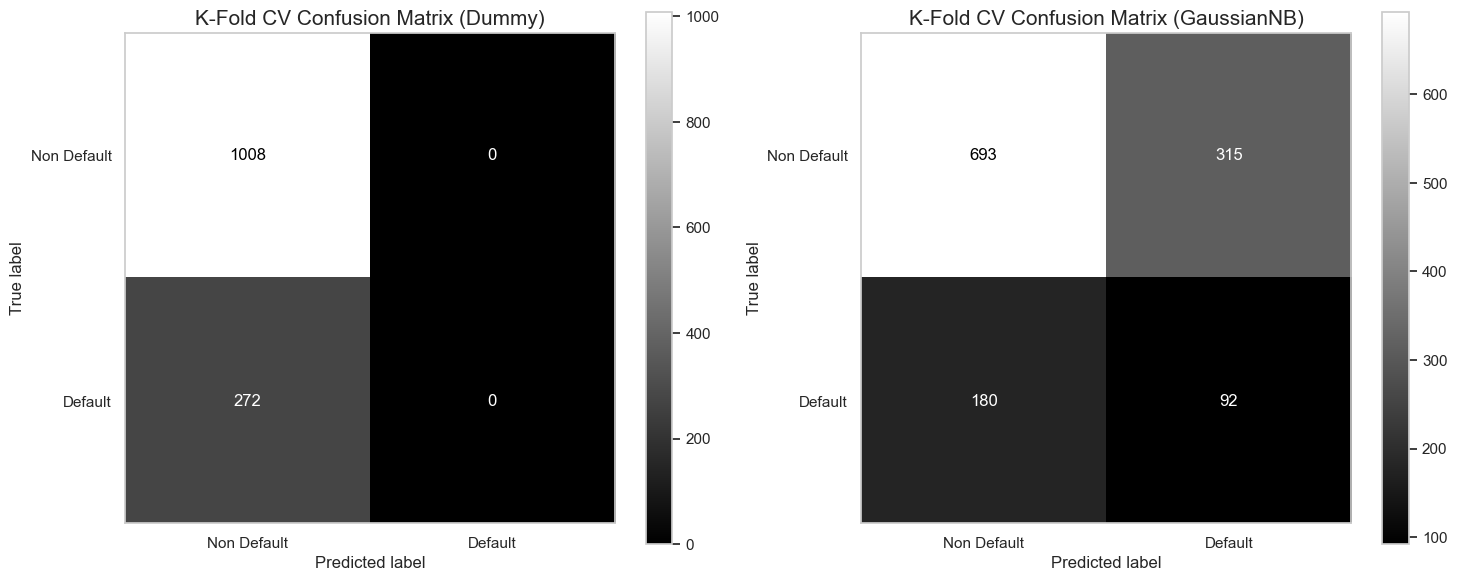

In [279]:
steps[step] = ('Dummy', DummyClassifier())
dummy = Pipeline(steps=steps)

labels = ['Non Default', 'Default']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

dummy.fit(X_train, y_train)
pred_d = cross_val_predict(dummy, X_train, y_train)
cm_d = confusion_matrix(y_train, pred_d) 
disp_d = ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=labels)
disp_d.plot(ax=axes[0], cmap='gist_gray')
axes[0].grid(False)
axes[0].set_title(f'K-Fold CV Confusion Matrix (Dummy)', fontsize=15)

steps[step] = ('GaussianNB', GaussianNB())
gnb = Pipeline(steps=steps)

gnb.fit(X_train, y_train)
pred_g = cross_val_predict(gnb, X_train, y_train)
cm_g = confusion_matrix(y_train, pred_g) 
disp_g = ConfusionMatrixDisplay(confusion_matrix=cm_g, display_labels=labels)
disp_g.plot(ax=axes[1], cmap='gist_gray')
axes[1].grid(False)
axes[1].set_title(f'K-Fold CV Confusion Matrix (GaussianNB)', fontsize=15)

plt.tight_layout()
plt.show()

**Can you say anything about the errors that the system makes?**

* From the confusion matrix, we observe that the GaussianNB model performs better than the dummy classifier
* However the its results are still quite poor and could be improved
* Why does our dummy have no positive predictions?:
    - Our dummy uses the 'stratified' strategy for prediction
    - This strategy generates predictions by respecting the training set's class distribution
    - As the distribution of our data is imbalanced and has more of the negative class (Non Defaulters), the dummy classifier constantly predicts the negative class
    - This results in no true postives and false positives


# Improving the model

# Hyperparameter Tuning

**Did you try to tune the hyperparameters of the learning algorithm, and in that case how?**

* For hyperparamter tuning, I will use GridSearchCV
* GridSearchCV tries all the combinations of the values passed in the dictionary for a hyperparameter and evaluates the model for each combination using the Cross-Validation method
* Using this function allows us to get the optimal set of hyperparameters of every combination of hyperparameters 

**Hyperparamters of GaussianNB**

In [280]:
steps[step] = ('GaussianNB', GaussianNB())
gnb = Pipeline(steps=steps)

In [281]:
print("GaussianNB Hyperparameters:")
print("======================================")
for param_name in gnb.get_params().keys():
    print(param_name)

GaussianNB Hyperparameters:
memory
steps
verbose
preprocessing
GaussianNB
preprocessing__n_jobs
preprocessing__remainder
preprocessing__sparse_threshold
preprocessing__transformer_weights
preprocessing__transformers
preprocessing__verbose
preprocessing__verbose_feature_names_out
preprocessing__Numeric
preprocessing__Numeric__memory
preprocessing__Numeric__steps
preprocessing__Numeric__verbose
preprocessing__Numeric__Scaler
preprocessing__Numeric__Scaler__copy
preprocessing__Numeric__Scaler__norm
GaussianNB__priors
GaussianNB__var_smoothing


In [282]:
priors = [None, [0.25, 0.75], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]
var_smoothing = [1e-9, 1e-8, 1e-7, 1e-6]

params = {
    'GaussianNB__priors' : priors,
    'GaussianNB__var_smoothing': var_smoothing,
}

gnb_cv = GridSearchCV(gnb, param_grid=params, n_jobs=-1, scoring='recall')
gnb_cv.fit(X_train, y_train)

n_estimators = gnb_cv.best_params_['GaussianNB__priors']
min_samples_leaf = gnb_cv.best_params_['GaussianNB__var_smoothing']

for param in gnb_cv.best_params_:
    print(f'{param}: {gnb_cv.best_params_[param]}')

print(gnb_cv.best_score_)

GaussianNB__priors: [0.25, 0.75]
GaussianNB__var_smoothing: 1e-09
0.9226262626262626


# GaussianNB with tuned hyperparamters

* I will now train a GaussianNB model with the optimal parameter values

In [283]:
steps[step] = ('GaussianNB', GaussianNB(priors=[0.25, 0.75], var_smoothing=1e-09))
gnb_tuned = Pipeline(steps=steps)
gnb_tuned.fit(X_train, y_train)
pred = gnb_tuned.predict(X_test)
cv_score = cross_val_score(gnb_tuned, X_train, y_train, cv=cv, scoring='recall')
print(classification_report(y_test, pred, digits=3))
print(np.mean(cv_score))

              precision    recall  f1-score   support

           0      0.884     0.151     0.258       252
           1      0.227     0.926     0.365        68

    accuracy                          0.316       320
   macro avg      0.556     0.539     0.311       320
weighted avg      0.744     0.316     0.280       320

0.9707594457842721


# Validation Curves

* A validation curve helps visualize the performance of our model over different values for hyperparamters

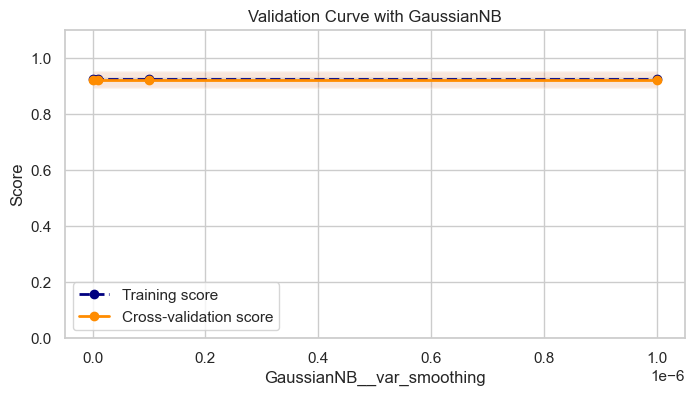

In [284]:
plot_validation_curve_range(gnb, X_train, y_train, 'GaussianNB__var_smoothing', [1e-9, 1e-8, 1e-7, 1e-6])
plt.show()

# Final Model


* Evaluate the model using the unseen data (test set) and see how well it performs

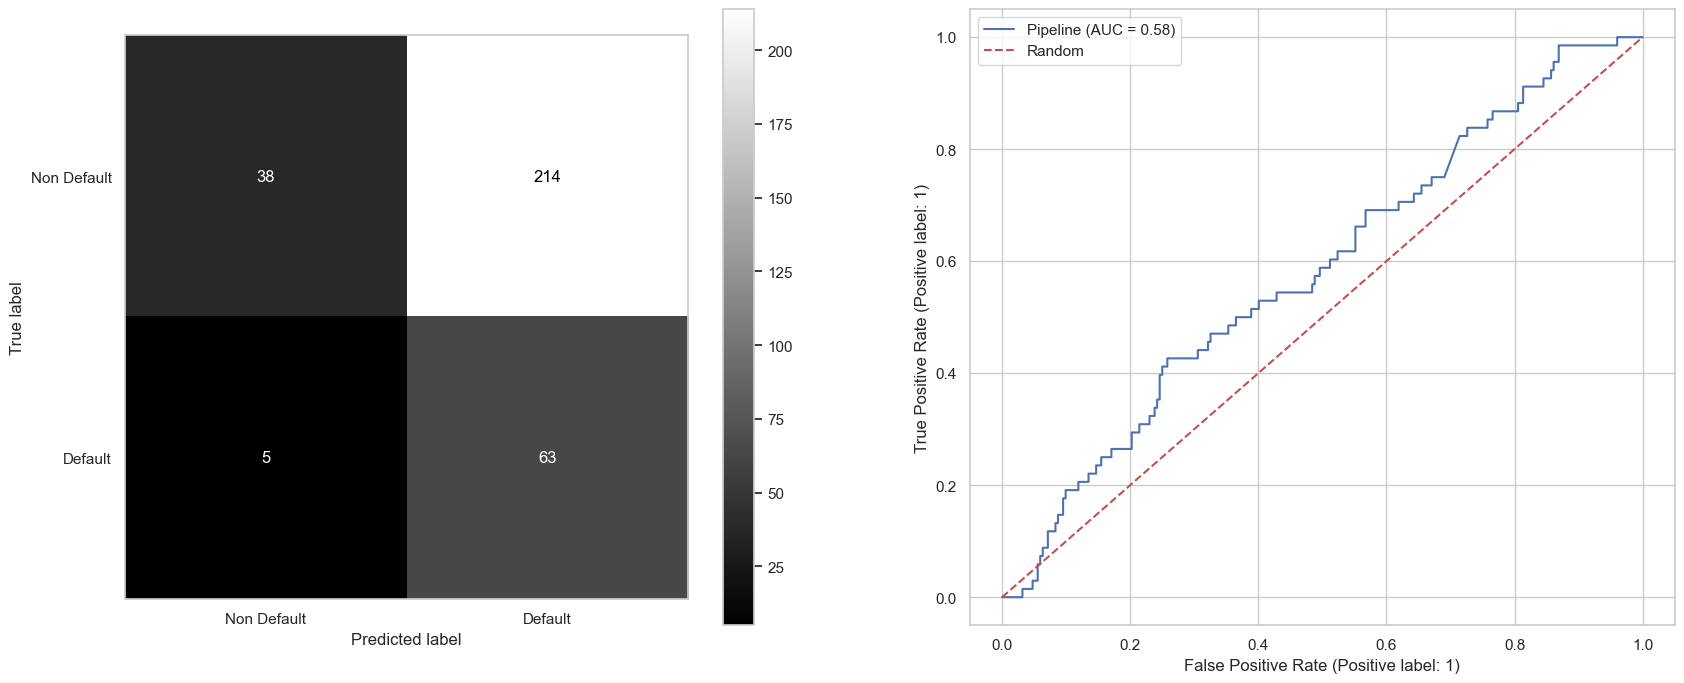

In [285]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

y_pred = gnb_tuned.predict(X_test) 
cm = confusion_matrix(y_test, y_pred) 

display_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display_test.plot(ax=axes[0], cmap='gist_gray')

RocCurveDisplay.from_estimator(gnb_tuned, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
axes[1].legend()

axes[0].grid(None)
plt.show()

**Results Explanantion**
* If we look at the ROC Curve, we notice that the GuassianNB model does not perform that well, with an AUC of 0.58 which is only slightly better than a random guess (AUC = 0.5)
* This is probably because our **True Positive Rate is high** however our **False Positive Rate is low**
* However, if we were looking at recall score, it is not neccessarily bad as we were able to correctly identify a high percentage of defaulters (65 out of 68)

# Permutation Feature Importance

[-0.01375    0.008125   0.00875    0.0090625 -0.035625  -0.025625
 -0.00875   -0.040625   0.         0.         0.         0.       ]


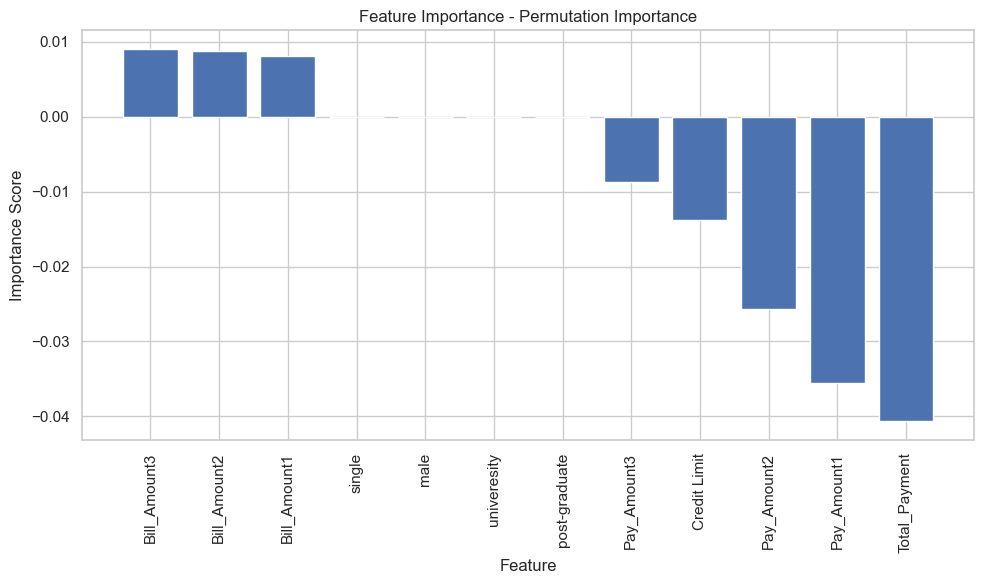

In [286]:
imps = permutation_importance(gnb, X_test, y_test, n_repeats=10, random_state=42)
print(imps.importances_mean)

importance_scores = imps.importances_mean

features = X_train.columns

sorted = importance_scores.argsort()[::-1]
sorted_importance_scores = importance_scores[sorted]
sorted_feature_names = features[sorted]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance_scores)), sorted_importance_scores)
plt.xticks(range(len(sorted_importance_scores)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance - Permutation Importance')
plt.tight_layout()
plt.show()

* Using permutation feature importance, it tells us that model performs better with the removal of features that have a negative importance score
* However, another way we could percieve this, is by comparing the importance scores of features and ranking them
* This would mean that Bill_Amount3 is the most important feature, and the least important feature would be Total_Payment 

# Additional (How could we change some steps to better the model)

**What other things could be done to improve the performance of the model?** (Outside of requirements for CA1)

**<font size=5>1) Feature Selection (Categorical Variables)**

* Previously I have actually performed a form of feature selection by removing the 'Age' (and 'Customer ID') column after observing that it had extremely low correlation with other variables besides itself
* Now I will perform feature selection using **scikit learn's chi-square feature selection**, to determine the most redundant categorical feature(s)

In [287]:
X1 = credit_df.drop(['Customer ID', 'Age', 'Default payment next month'], axis=1)
y1 = credit_df[['Default payment next month']]

# Split the data into train and test sets
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X1, y1, stratify=y, shuffle=True, test_size=.2, random_state=24)


# Extract Categorical variables
X_fs = X_train_fs.drop(columns=['Credit Limit', 'Bill_Amount1', 'Bill_Amount2',
                                'Bill_Amount3', 'Pay_Amount1', 'Pay_Amount2',
                                'Pay_Amount3', 'Total_Payment'], axis=1)

y_fs = y_train_fs

# Encode education column using label encoder
for col in X_fs.columns:
    le = LabelEncoder()
    X_fs[col] = le.fit_transform(X_fs[col])


In [288]:
chi_scores = chi2(X_fs, y_fs)
chi_scores

(array([0.11114212, 0.15646997, 0.40668119]),
 array([0.73884758, 0.69242755, 0.52365883]))

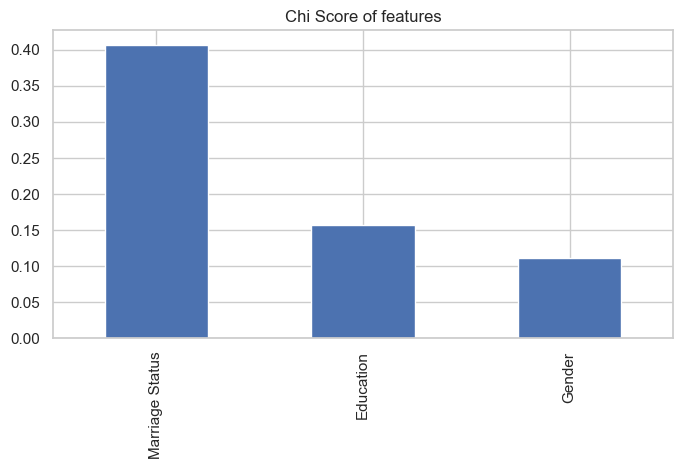

In [289]:
# Chi Score
chi_values = pd.Series(chi_scores[0], index=X_fs.columns)
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()
plt.title('Chi Score of features')
plt.show()

* The higher the chi score, the higher the importance
* Therefore, based on the bar chart above, we might consider dropping the Education and Gender features when comparing their importance with Marriage Status

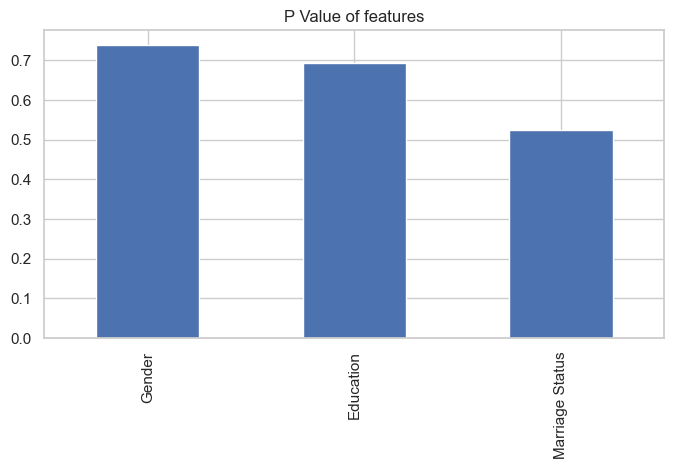

In [290]:
# P value
p_values = pd.Series(chi_scores[1], index=X_fs.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()
plt.title('P Value of features')
plt.show()

* Another way to determine which features to drop would be looking at the P-Value
* For Chi-Square, a significance level of 0.05 (5%) is commonly used to determine the importance of a feature (if p-value < 0.05, features is statistically significant vice versa)
* Upon observing the p-values of each feature, we see that they largely exceed the significance level of 0.05
* This information prompts us to **consider droppping all three of these features**

**<font size=5> 2) Oversampling target feature**

* To deal with the imbalance in the data, we can introduce sampling methods such as oversampling or undersampling
* We should perform oversampling here as our dataset is considered small
* Within oversampling there are also techniques we can apply to our dataset
* Two of the popular techniques are **Random Over Sampling** and **Synthetic Minority Over-sampling Technique for Nominal and Continuous features (SMOTE-NC)**

**<font size=3>
Random Over Sampling**

* Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset

<img src="../../pictures/random_oversampling.png" alt="random oversampling">

In [291]:
ros = RandomOverSampler(random_state=42)
X_random_res, y_random_res = ros.fit_resample(X_training, y_training)

print(X_random_res.shape, y_random_res.shape)

(2016, 12) (2016, 1)


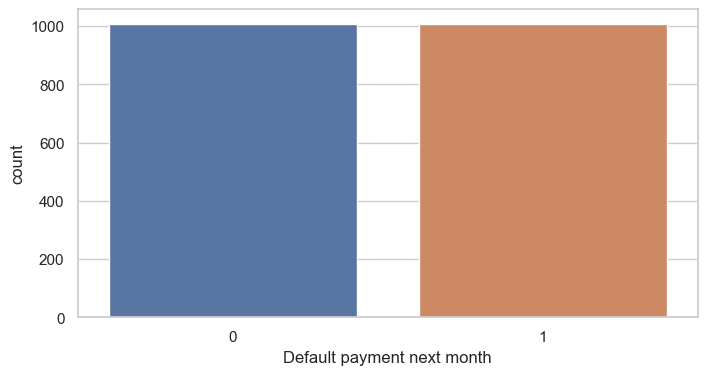

In [292]:
sns.countplot(x = 'Default payment next month', data = y_random_res)
plt.show()

**<font size=3>
SMOTE-NC**
    
* Another popular technique used for oversampling would be Synthetic Minority Over-sampling Technique for Nominal and Continuous features (SMOTE-NC) derived from SMOTE 
* We use SMOTE-NC instead of SMOTE as we have categorical features(3) and continuous features(7)

**<font size=3>
SMOTE-NC Explained**

* In SMOTE-NC, a distance metric(Euclidian and Jaccard) is first computed between the instances from the minority class. 
* The synthetic instances are then generated by selecting a minority instance and one of its k-nearest neighbors. 
    
* For nominal features, the Jaccard distance is commonly used. Simply put, the Jaccard distance measures the dissimilarity between two sets of categorical features by calculating the ratio of the size of their intersection to the size of their union.
    
* For continuous features, the Euclidean distance is often used. Simply put, the Euclidean distance measures the straight-line distance between two points in a multi-dimensional space (principle of the Pythagoras theorem).

<img src="../../pictures/SMOTE-NC.png" alt="SMOTE-NC">

In [293]:
categorical_features = [1, 2, 3]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_smotenc_res, y_smotenc_res = smote_nc.fit_resample(X_training, y_training)

print(X_smotenc_res.shape, y_smotenc_res.shape)

(2016, 12) (2016, 1)


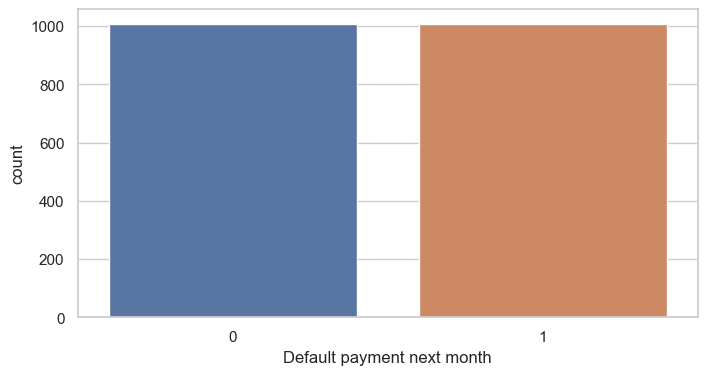

In [294]:
sns.countplot(x = 'Default payment next month', data = y_smotenc_res)
plt.show()

**Scoring the models after oversampling**

In [295]:
metrics = ['precision', 'accuracy', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

models = [
    ("KNeighborsClassifer", KNeighborsClassifier()), 
    ("LogRegClassifier", LogisticRegression()), 
    ("DecisionTreeClassifer", DecisionTreeClassifier()), 
    ("RandomForestClassifier", RandomForestClassifier()), 
    ("GradientBoostClassifier", GradientBoostingClassifier()),
    ('SGDClassifier', SGDClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GaussianNB', GaussianNB()), # Naive Bayes
    # ('Dummy', DummyClassifier())
    ('ExtraTreesClassifier', ExtraTreesClassifier())
]

score_random = score_models_simple(X_random_res, y_random_res, models, metrics, cv)
score_smotenc = score_models_simple(X_smotenc_res, y_smotenc_res, models, metrics, cv)

**Random Oversampling Score**

In [296]:
score_random.sort_values(by=['test_recall'], ascending=False).style.apply(
    lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
).apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
)

,fit_time,score_time,test_precision,train_precision,test_accuracy,train_accuracy,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DecisionTreeClassifer,0.023717,0.051335,0.797517,0.983127,0.860891,0.990199,0.968523,0.997502,0.874250,0.990258,0.867431,0.999641
RandomForestClassifier,0.625752,0.084788,0.891732,0.981694,0.923267,0.990199,0.963851,0.999009,0.926071,0.990273,0.970680,0.999302
ExtraTreesClassifier,0.316407,0.084300,0.920128,0.983127,0.932673,0.990199,0.947655,0.997502,0.933559,0.990258,0.976949,0.999641
GaussianNB,0.005585,0.032641,0.523273,0.519377,0.536634,0.532878,0.869309,0.874269,0.652716,0.651399,0.569121,0.564203
GradientBoostClassifier,0.732081,0.042852,0.748469,0.852932,0.760396,0.859801,0.789865,0.869464,0.767386,0.860975,0.833498,0.931403
KNeighborsClassifer,0.016958,0.082489,0.648829,0.742543,0.678218,0.793548,0.785794,0.898095,0.709630,0.812917,0.747383,0.895651
AdaBoostClassifier,0.251776,0.066945,0.679453,0.735464,0.671782,0.730273,0.665699,0.718146,0.669565,0.726634,0.736818,0.806674
LogRegClassifier,0.039084,0.074949,0.596000,0.585748,0.592574,0.590199,0.608346,0.610789,0.597530,0.597579,0.634510,0.625563
SGDClassifier,0.013096,0.054310,0.585483,0.593405,0.545050,0.551489,0.510629,0.524879,0.468703,0.482238,0.615210,0.621188


**SMOTE-NC Score**

In [297]:
score_smotenc.sort_values(by=['test_recall'], ascending=False).style.apply(
    lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
).apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
)

,fit_time,score_time,test_precision,train_precision,test_accuracy,train_accuracy,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
GaussianNB,0.005186,0.036309,0.521871,0.527130,0.535644,0.547022,0.892023,0.904863,0.658027,0.666148,0.563557,0.570012
ExtraTreesClassifier,0.367815,0.092759,0.822689,0.992555,0.818317,0.993300,0.814778,0.994041,0.818114,0.993296,0.885254,0.999820
RandomForestClassifier,0.795920,0.091479,0.803926,0.992555,0.799010,0.993300,0.794100,0.994041,0.798402,0.993296,0.869683,0.997835
SGDClassifier,0.016875,0.050667,0.533660,0.545226,0.546535,0.554839,0.778489,0.784537,0.613685,0.624514,0.597789,0.599672
DecisionTreeClassifer,0.026935,0.048281,0.697178,0.992555,0.703960,0.993300,0.722233,0.994041,0.709347,0.993296,0.703063,0.999820
KNeighborsClassifer,0.006783,0.063916,0.720403,0.807782,0.716832,0.805335,0.717346,0.800719,0.717262,0.804223,0.768923,0.886987
GradientBoostClassifier,0.968010,0.048271,0.743511,0.866357,0.728218,0.848759,0.702826,0.824374,0.721315,0.844763,0.805084,0.930007
AdaBoostClassifier,0.273083,0.067226,0.661059,0.699027,0.658416,0.696402,0.660155,0.689062,0.659409,0.693726,0.709474,0.776216
LogRegClassifier,0.033709,0.066459,0.593420,0.578772,0.593069,0.584615,0.613777,0.617058,0.601834,0.597016,0.622216,0.622174


* With the addition of oversampling, we can observe that the scores (even when using both oversampling techniques) have a large improvement in comparison to no oversampling
* Now lets evaluate the GaussianNB model after training it with the data oversampled using SMOTE-NC as it produced better results compared to Random Over Sampling (0.892 test_recall and 0.869 test_recall respectively)
* Additionally, SMOTE_NC seems to be a better technique than Random Over Sampling as it reduces the risk of overfitting

**<font size=5>
Quick Evaluation**

**Tuning:**

In [298]:
gnb = GaussianNB()

In [299]:
priors = [None, [0.25, 0.75], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]
var_smoothing = [1e-9, 1e-8, 1e-7, 1e-6]

params = {
    'priors' : priors,
    'var_smoothing': var_smoothing,
}

gnb_cv = GridSearchCV(gnb, param_grid=params, n_jobs=-1, scoring='recall')
gnb_cv.fit(X_smotenc_res, y_smotenc_res)

priors = gnb_cv.best_params_['priors']
var_smoothing = gnb_cv.best_params_['var_smoothing']

for param in gnb_cv.best_params_:
    print(f'{param}: {gnb_cv.best_params_[param]}')

print(gnb_cv.best_score_)

priors: [0.25, 0.75]
var_smoothing: 1e-09
0.9196394266292302


In [300]:
gnb_tuned = GaussianNB(priors=[0.25, 0.75], var_smoothing=1e-09)
gnb_tuned.fit(X_smotenc_res, y_smotenc_res)
pred = gnb_tuned.predict(X_test)
cv_score = cross_val_score(gnb_tuned, X_smotenc_res, y_smotenc_res, cv=cv, scoring='recall')
print(classification_report(y_test, pred, digits=3))
print(np.mean(cv_score))

              precision    recall  f1-score   support

           0      0.842     0.464     0.598       252
           1      0.254     0.676     0.369        68

    accuracy                          0.509       320
   macro avg      0.548     0.570     0.484       320
weighted avg      0.717     0.509     0.550       320

0.90796270335978


**Evaluation:**

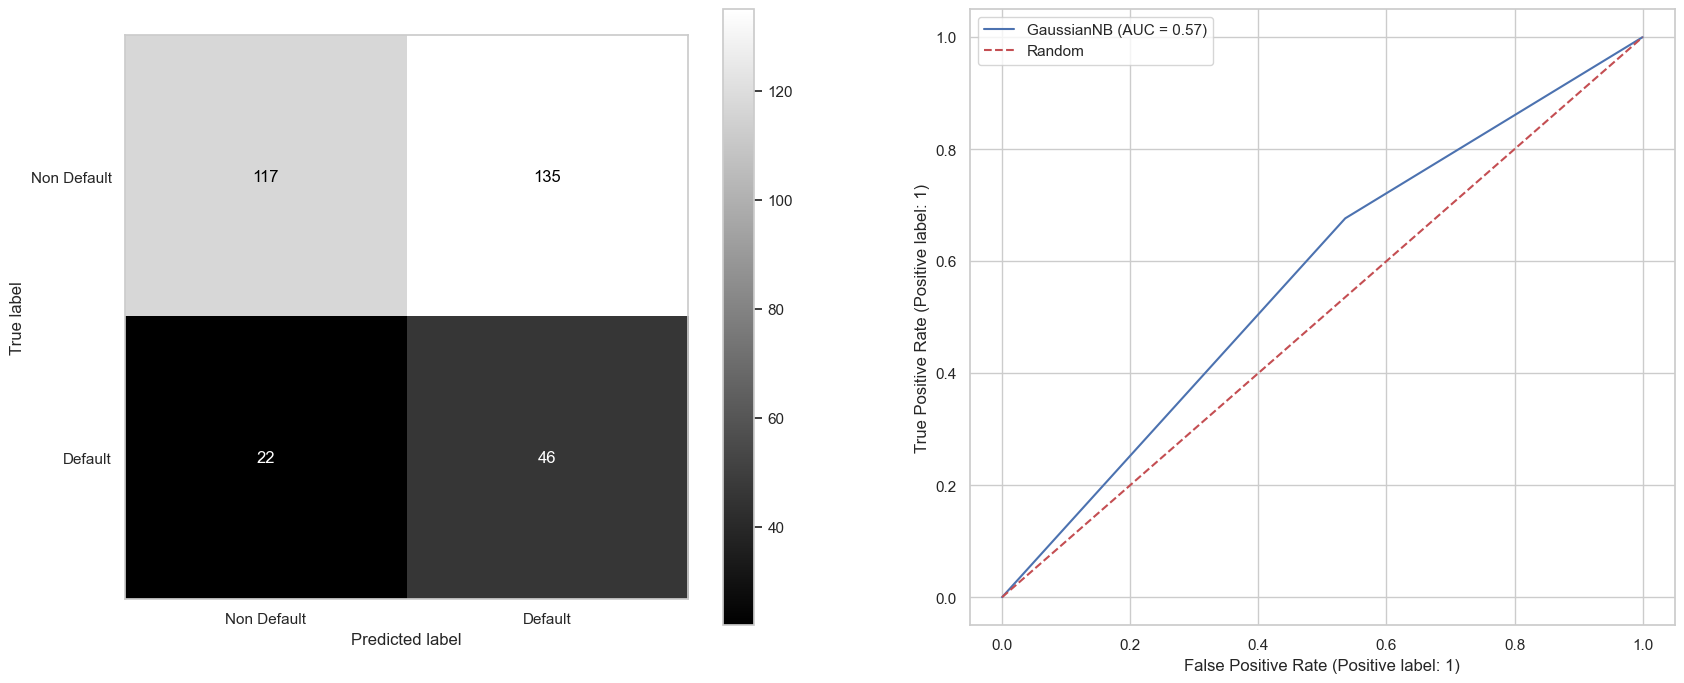

In [301]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

y_pred = gnb_tuned.predict(X_test) 
cm = confusion_matrix(y_test, y_pred) 

display_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display_test.plot(ax=axes[0], cmap='gist_gray')

RocCurveDisplay.from_estimator(gnb_tuned, X_test, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
axes[1].legend()

axes[0].grid(None)
plt.show()

**Results Explanation**

* From our ROC Curve, we see that it performs slightly worser compared to our initial model
* This is perculiar as with the addition of techniques such as oversampling, one would expect the results to improve
* Looking at our confusion matrix too, we notice a few differences:
    * The amount of true postives have decreased (false negatives increase)
    * However, the amount of **true negatives increased (false postives decreased)**
* Though this model performs worse (in terms of recall) compared to our initial model, it makes up for it by being able to **correctly predict more people who did not default**
* Hence, if we were going for a more balanced model (trying to correcly identify as many defaulters and non defaulters), this model would be more appropriate